In [1]:
import os
import random
import itertools
import re

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# データセット分割
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    ShuffleSplit,
    StratifiedShuffleSplit,
)

# 補完
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# エンコード
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

# サンプリング
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 特徴量選択
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import (
    GenericUnivariateSelect,
    f_classif,
    mutual_info_classif,
    chi2,
)
from boruta import BorutaPy
from libraries.mrmr import mrmr

# models
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier


# 学習中
import optuna
from tqdm import tqdm
from sklearn.model_selection import learning_curve, cross_validate, cross_val_score

# 評価指標
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings


# config python file
import config

SEED = config.SEED
# INDEX_MICROARRAY = config.INDEX_MICROARRAY
INDEX_MICROARRAY = 2
from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

# 目的
遺伝子学的分類に基づいた、予後の2値分類を実施する。  
分類はCLAUDIN_SUBTYPEに基づいて実施。  
予後は5年、10年、15年の3つの年次に分けている。Trueで死亡であることに注意すること。

# データ読み込み
読み込み元：
    config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/claudin_subtype_chi2"

サブタイプ毎のデータを使用 

In [19]:
X_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/X_dict.pickle")
y_dict = pickle_load(config.INTERIM_PREPROCESSED_PROGNOSIS_CROSS_DIR + "/y_dict.pickle")

# データ全体での予測モデル検証

## ベースモデルの学習結果

各特徴量選択されたdfを用いて基本的な2値分類モデルを学習する

In [9]:
def validate_models(microarray_type: str, method: str, sampling_type: str = None):
    for year in range(15, 16, 5):  # 予後年数毎のループ
        prognosis_Xlabel = "X{0}".format(year)
        prognosis_ylabel = "y{0}".format(year)

        # compare_bcmsは内部でk分割交差検証を行うので、train_test_splitをしなくて良い
        X_train = X_dict[microarray_type][method]["train"][prognosis_Xlabel]
        y_train = y_dict[microarray_type][method]["train"][prognosis_ylabel]
        X_val = X_dict[microarray_type][method]["val"][prognosis_Xlabel]
        y_val = y_dict[microarray_type][method]["val"][prognosis_ylabel]

        # accuracyの表示
        print("----------" * 10)
        print("予後年数：{0}年:".format(year))
        if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
            score = (
                "0>1".format(year),
                round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
            )
        else:
            score = (
                "0>1".format(year),
                round(accuracy_score(y_train, np.ones(len(y_train))), 3),
            )
        print("accuracyベースライン：", score)
        print("使用特徴量：", X_train.columns)
        print("学習サンプルサイズ：", X_train.shape)
        display("ラベル比率：", y_train.value_counts())
        save_dir = (
            config.TABLES_MODELS_PROGNOSIS_CROSS_DIR
            + "/scores_base-model/{0}/{1}".format(microarray_type, method)
        )
        make_dir(save_dir)
        sampling = None
        if sampling_type == "sm":
            sampling = SMOTE(random_state=SEED)
        display(
            compare_bcms(
                X_train,
                y_train,
                X_val,
                y_val,
                over_sampling_class=sampling,
                save_path=save_dir + "/{0}.csv".format(year),
            )
        )

In [4]:
for k in X_dict.keys():
    print(k)
    validate_models(microarray_type=k, method="mrmr", sampling_type=None)
    validate_models(microarray_type=k, method="mrmr", sampling_type="sm")
    # validate_models(microarray_type=k, method="boruta")

mrna_agilent_microarray_zscores_ref_all_samples
----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.533)
使用特徴量： Index(['RACGAP1', 'PFN4', 'NACAP1', 'RAPGEF5', 'EMR3', 'CXorf57', 'DNAJB7',
       'ENC1', 'PCM1', 'KRTAP12-4', 'STAT5B', 'AI659947', 'TOR1B', 'BP432397',
       'RNU11', 'UHRF1', 'RBBP8', 'USP30', 'AK022229', 'FGF13', 'BE858513',
       'HS3ST1', 'DFNB59', 'GAL3ST4', 'AURKA', 'DB341438', 'C9orf95', 'S100P',
       'ANKAR', 'WDR67', 'GABRB1', 'AW572907', 'HIST1H2BF', 'APLN', 'GTPBP5',
       'SPATA4', 'BG218808', 'AW444974', 'FGD3', 'INTS10', 'CBX7', 'BC033399',
       'TSPYL6', 'TMEM26', 'DA697821', 'MST1', 'IGDCC4', 'UBE2C', 'RAB3B'],
      dtype='object')
学習サンプルサイズ： (865, 49)


'ラベル比率：'

1    461
0    404
Name: OS_15years, dtype: int64

11it [00:02,  5.18it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Random Forest,0.870520,0.649485,0.881356,0.679245
Sigmoid SVM,0.757225,0.628866,0.781705,0.678571
AdaBoost,0.854335,0.639175,0.865385,0.672897
RBF SVM,0.915607,0.597938,0.920044,0.648649
Logistic Regression,0.806936,0.608247,0.821772,0.648148
Linear SVM,0.810405,0.587629,0.825532,0.636364
Polynomial SVM,0.966474,0.577320,0.968306,0.630631
Naive Bayes,0.736416,0.567010,0.753247,0.596154
Nearest Neighbors,0.800000,0.567010,0.814973,0.596154


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.533)
使用特徴量： Index(['RACGAP1', 'PFN4', 'NACAP1', 'RAPGEF5', 'EMR3', 'CXorf57', 'DNAJB7',
       'ENC1', 'PCM1', 'KRTAP12-4', 'STAT5B', 'AI659947', 'TOR1B', 'BP432397',
       'RNU11', 'UHRF1', 'RBBP8', 'USP30', 'AK022229', 'FGF13', 'BE858513',
       'HS3ST1', 'DFNB59', 'GAL3ST4', 'AURKA', 'DB341438', 'C9orf95', 'S100P',
       'ANKAR', 'WDR67', 'GABRB1', 'AW572907', 'HIST1H2BF', 'APLN', 'GTPBP5',
       'SPATA4', 'BG218808', 'AW444974', 'FGD3', 'INTS10', 'CBX7', 'BC033399',
       'TSPYL6', 'TMEM26', 'DA697821', 'MST1', 'IGDCC4', 'UBE2C', 'RAB3B'],
      dtype='object')
学習サンプルサイズ： (865, 49)


'ラベル比率：'

1    461
0    404
Name: OS_15years, dtype: int64

11it [00:01,  6.32it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Linear SVM,0.804772,0.618557,0.805195,0.666667
Decision Tree,0.825380,0.608247,0.825569,0.648148
Sigmoid SVM,0.752711,0.597938,0.760000,0.642202
Logistic Regression,0.795011,0.597938,0.796117,0.628571
RBF SVM,0.918655,0.577320,0.917127,0.616822
Naive Bayes,0.738612,0.587629,0.740581,0.615385
Random Forest,0.867679,0.587629,0.868817,0.607843
Quadratic Discriminant Analysis,0.881779,0.577320,0.877940,0.601942
AdaBoost,0.838395,0.587629,0.837514,0.600000


mrna_agilent_microarray
----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.533)
使用特徴量： Index(['RACGAP1', 'SNX24', 'TUB', 'ARRDC3', 'STAT5B', 'PTPLAD1', 'RBBP8',
       'ENC1', 'RNU11', 'UHRF1', 'PPIL3', 'S100P', 'MST1', 'WARS2', 'FGF13',
       'C9orf95', 'WDR67', 'CBX7', 'INTS10', 'SPATA18', 'HIST1H2BF', 'AURKA',
       'TFPT', 'LRRC50', 'PDK3', 'IGDCC4', 'FGD3', 'AK3', 'LRRC48', 'PSTPIP2',
       'PKMYT1', 'CATSPERB', 'TMEM26', 'STAT5A', 'CCT6B', 'C14orf139',
       'C7orf63', 'CD44', 'KIAA1967', 'ATAD2', 'N4BP2L1', 'PIGV', 'GPRC5A',
       'UBE2C', 'OGT', 'TRNP1', 'PREX1', 'GPR172A', 'NAB1'],
      dtype='object')
学習サンプルサイズ： (865, 49)


'ラベル比率：'

1    461
0    404
Name: OS_15years, dtype: int64

11it [00:08,  1.23it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Decision Tree,0.817341,0.670103,0.833333,0.709091
Sigmoid SVM,0.532948,0.536082,0.695324,0.697987
Polynomial SVM,0.921387,0.608247,0.927505,0.648148
Linear SVM,0.758382,0.628866,0.775991,0.647059
RBF SVM,0.758382,0.597938,0.778367,0.621359
Logistic Regression,0.749133,0.608247,0.768410,0.620000
Random Forest,0.836994,0.577320,0.852356,0.616822
Quadratic Discriminant Analysis,0.852023,0.597938,0.858720,0.613861
Nearest Neighbors,0.771098,0.556701,0.790254,0.590476


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.533)
使用特徴量： Index(['RACGAP1', 'SNX24', 'TUB', 'ARRDC3', 'STAT5B', 'PTPLAD1', 'RBBP8',
       'ENC1', 'RNU11', 'UHRF1', 'PPIL3', 'S100P', 'MST1', 'WARS2', 'FGF13',
       'C9orf95', 'WDR67', 'CBX7', 'INTS10', 'SPATA18', 'HIST1H2BF', 'AURKA',
       'TFPT', 'LRRC50', 'PDK3', 'IGDCC4', 'FGD3', 'AK3', 'LRRC48', 'PSTPIP2',
       'PKMYT1', 'CATSPERB', 'TMEM26', 'STAT5A', 'CCT6B', 'C14orf139',
       'C7orf63', 'CD44', 'KIAA1967', 'ATAD2', 'N4BP2L1', 'PIGV', 'GPRC5A',
       'UBE2C', 'OGT', 'TRNP1', 'PREX1', 'GPR172A', 'NAB1'],
      dtype='object')
学習サンプルサイズ： (865, 49)


'ラベル比率：'

1    461
0    404
Name: OS_15years, dtype: int64

11it [00:04,  2.65it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Sigmoid SVM,0.500000,0.536082,0.666667,0.697987
Decision Tree,0.798265,0.608247,0.798701,0.634615
Polynomial SVM,0.927332,0.608247,0.927568,0.634615
Linear SVM,0.761388,0.608247,0.763441,0.620000
Logistic Regression,0.747289,0.618557,0.745911,0.618557
Quadratic Discriminant Analysis,0.851410,0.597938,0.848283,0.606061
Random Forest,0.845987,0.577320,0.848291,0.594059
AdaBoost,0.824295,0.597938,0.824295,0.589474
RBF SVM,0.757050,0.577320,0.760171,0.585859


mrna_agilent_microarray_zscores_ref_diploid_samples
----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.533)
使用特徴量： Index(['RACGAP1', 'CYP2D6', 'PTX4', 'BIK', 'ENC1', 'DENND6A', 'STAT5B',
       'RNU11', 'DNAJB7', 'PPIL3', 'UHRF1', 'RBBP8', 'MIR137HG', 'GABRB1',
       'TOR1B', 'MST1', 'NMRK1', 'FGF13', 'HIST1H2BF', 'SPATA4', 'TBC1D31',
       'USP30', 'S100P', 'APLN', 'MTG2', 'GAL3ST4', 'FGD3', 'PJVK', 'INTS10',
       'CBX7', 'FCN2', 'RNASE9', 'SPATA18', 'ANKAR', 'SULT4A1', 'TSPYL6',
       'IGDCC4', 'TMEM26', 'PDK3', 'AURKA', 'PRR21', 'DNAAF1', 'GPR151',
       'GASK1A', 'NLRX1', 'RAB3B', 'HS3ST1', 'PKMYT1', 'CATSPERB'],
      dtype='object')
学習サンプルサイズ： (865, 49)


'ラベル比率：'

1    461
0    404
Name: OS_15years, dtype: int64

11it [00:01,  6.04it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Logistic Regression,0.788439,0.649485,0.803437,0.673077
RBF SVM,0.893642,0.639175,0.900862,0.672897
Linear SVM,0.786127,0.618557,0.802982,0.654206
AdaBoost,0.856647,0.639175,0.865217,0.653465
Quadratic Discriminant Analysis,0.860116,0.639175,0.863585,0.653465
Sigmoid SVM,0.734104,0.618557,0.750542,0.647619
Random Forest,0.854335,0.597938,0.867925,0.635514
Nearest Neighbors,0.786127,0.597938,0.798694,0.628571
Naive Bayes,0.746821,0.597938,0.760131,0.613861


----------------------------------------------------------------------------------------------------
予後年数：15年:
accuracyベースライン： ('0>1', 0.533)
使用特徴量： Index(['RACGAP1', 'CYP2D6', 'PTX4', 'BIK', 'ENC1', 'DENND6A', 'STAT5B',
       'RNU11', 'DNAJB7', 'PPIL3', 'UHRF1', 'RBBP8', 'MIR137HG', 'GABRB1',
       'TOR1B', 'MST1', 'NMRK1', 'FGF13', 'HIST1H2BF', 'SPATA4', 'TBC1D31',
       'USP30', 'S100P', 'APLN', 'MTG2', 'GAL3ST4', 'FGD3', 'PJVK', 'INTS10',
       'CBX7', 'FCN2', 'RNASE9', 'SPATA18', 'ANKAR', 'SULT4A1', 'TSPYL6',
       'IGDCC4', 'TMEM26', 'PDK3', 'AURKA', 'PRR21', 'DNAAF1', 'GPR151',
       'GASK1A', 'NLRX1', 'RAB3B', 'HS3ST1', 'PKMYT1', 'CATSPERB'],
      dtype='object')
学習サンプルサイズ： (865, 49)


'ラベル比率：'

1    461
0    404
Name: OS_15years, dtype: int64

11it [00:02,  4.99it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Quadratic Discriminant Analysis,0.869848,0.690722,0.864253,0.705882
Logistic Regression,0.780911,0.670103,0.781857,0.686275
Decision Tree,0.815618,0.639175,0.818376,0.672897
RBF SVM,0.903471,0.639175,0.901874,0.666667
Sigmoid SVM,0.732104,0.649485,0.730055,0.666667
Linear SVM,0.799349,0.628866,0.801715,0.660377
Random Forest,0.861171,0.628866,0.862069,0.640000
AdaBoost,0.848156,0.618557,0.845815,0.626263
Naive Bayes,0.749458,0.597938,0.748092,0.613861


## lightGBM

In [13]:
X_train = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["train"]["X15"]
y_train = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["train"]["y15"]
X_val = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["val"]["X15"]
y_val = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["val"]["y15"]

params = {
    "max_bin": 100,
    "num_leaves": 30,
    "n_estimators": 800,
    "class_weight": "balanced",
    "random_state": SEED,
}

gbm = LGBMClassifier(**params)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_val)
show_scores(y_val, y_pred)

accuracy:  0.6391752577319587
precision:  0.6545454545454545
recall:  0.6923076923076923
f1 score:  0.6728971962616823


## xgboost

In [5]:
import xgboost as xgb

X_train = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["train"]["X15"]
y_train = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["train"]["y15"]
X_val = X_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["val"]["X15"]
y_val = y_dict[config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]]["mrmr"]["val"]["y15"]

xgb_train = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns)
xgb_val = xgb.DMatrix(X_val, label=y_val, feature_names=X_val.columns)


param = {
    # 二値分類問題
    "objective": "binary:logistic",
}
clf = xgb.train(param, xgb_train)
y_pred_proba = clf.predict(xgb_val)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

accuracy_score(y_val, y_pred), f1_score(y_val, y_pred)

[05:23:04] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


(0.6494845360824743, 0.6730769230769231)

## モデル毎の比較（年数など）

### 予測モデル、特徴量数、年数毎の比較

In [5]:
def model2result_list(
    clf: callable,
    X_train: pd.DataFrame(),
    y_train: pd.DataFrame(),
    X_test: pd.DataFrame(),
    y_test: pd.DataFrame(),
    model_name: str,
    year: int,
    k: int,
) -> list():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    return [year, model_name, acc, pre, rec, f1, k]

In [6]:
row = []
fold = 5
for year in tqdm(range(15, 16, 5)):  # 予後年数毎のループ
    prognosis_Xlabel = "X{0}".format(year)
    prognosis_ylabel = "y{0}".format(year)
    for k in range(10, 51, 10):
        tmp = None
        X = X_dict["mrna_agilent_microarray_zscores_ref_diploid_samples"]["mrmr"][
            "train"
        ][prognosis_Xlabel]
        y = y_dict["mrna_agilent_microarray_zscores_ref_diploid_samples"]["mrmr"][
            "train"
        ][prognosis_ylabel]

        skf = StratifiedKFold(n_splits=fold, shuffle=True, random_state=SEED)
        for train_index, val_indes in skf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_indes]
            y_train, y_val = y.iloc[train_index], y.iloc[val_indes]

            assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
            assert X_val.shape[0] == y_val.shape[0], "test size is incorrect"

            # 特徴量選択の実施（mRMR）
            features = mrmr.mrmr_classif(
                X=X_train,
                y=y_train,
                K=k,
                show_progress=False,
            )

            # 特徴量選択で選ばれた特徴量の抽出（訓練、テストデータに適用）
            # list変換するのはfuture warningが出るため
            X_train = X_train[features]
            X_val = X_val[features]

            # スケーリングの実施
            X_train, X_val = transform_std(X_train, X_val)
            # X_train, X_val = transform_norm(X_train, X_val)

            # サンプリングの実装
            # positive_count_train = y_train.value_counts().sort_values()[0]
            rus = RandomUnderSampler(sampling_strategy="all", random_state=SEED)
            # smote = SMOTE(sampling_strategy="all", random_state=SEED)
            X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

            # accuracyの表示
            """
            print("予後年数：{0}年:".format(year))
            print("学習サンプルサイズ：", X_train.shape)
            display("ラベル比率：", y_train.value_counts())        
            """

            # ここからモデルのtrain、x軸をkとしたacc, f1の推移plot
            # print("Random Forest")
            params = {
                "n_estimators": 500,
                "criterion": "entropy",
                "max_depth": 5,
                "max_leaf_nodes": 20,
                "max_features": "log2",
                "class_weight": "balanced",
                "random_state": SEED,
            }
            rf = RandomForestClassifier(**params)
            tmp = model2result_list(rf, X_train, y_train, X_val, y_val, "rf", year, k)
            row.append(tmp)

            # print("Logistic Regression")
            params = {
                "penalty": "l2",
                "C": 0.5,
                "solver": "saga",
                "class_weight": "balanced",
            }
            lr = LogisticRegression(**params)
            tmp = model2result_list(lr, X_train, y_train, X_val, y_val, "lr", year, k)
            row.append(tmp)

            # print("Support Vector Machine")
            params = {
                "C": 50,
                "kernel": "sigmoid",
                "decision_function_shape": "ovr",
                "class_weight": "balanced",
            }
            svm = SVC(**params)
            tmp = model2result_list(svm, X_train, y_train, X_val, y_val, "svm", year, k)
            row.append(tmp)

    # 結果をdfにまとめている
    df_result = pd.DataFrame(
        row,
        columns=[
            "year",
            "model_name",
            "acc",
            "precision",
            "recall",
            "f1",
            "feature size",
        ],
    )

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:02<00:00, 122.37s/it]


In [7]:
df_result[df_result["model_name"] == "rf"].groupby(
    ["year", "feature size"]
).mean().sort_values("acc", ascending=False)

acc  precision    recall        f1
year feature size                                         
15   40            0.720231   0.734554  0.746166  0.739993
     50            0.720231   0.734554  0.746166  0.739993
     30            0.713295   0.725555  0.743922  0.734229
     20            0.683237   0.694121  0.728822  0.710235
     10            0.677457   0.695627  0.704979  0.699879

In [8]:
df_result[df_result["model_name"] == "lr"].groupby(
    ["year", "feature size"]
).mean().sort_values("acc", ascending=False)

acc  precision    recall        f1
year feature size                                         
15   40            0.732948   0.756673  0.737564  0.746544
     50            0.732948   0.756673  0.737564  0.746544
     30            0.715607   0.739345  0.722394  0.730340
     20            0.695954   0.725919  0.689808  0.707205
     10            0.690173   0.722748  0.681043  0.701143

In [9]:
df_result[df_result["model_name"] == "svm"].groupby(
    ["year", "feature size"]
).mean().sort_values("acc", ascending=False)

acc  precision    recall        f1
year feature size                                         
15   40            0.680925   0.712835  0.674638  0.692703
     50            0.680925   0.712835  0.674638  0.692703
     20            0.669364   0.697698  0.670266  0.683482
     30            0.669364   0.700168  0.670196  0.683615
     10            0.611561   0.653488  0.583567  0.615024

# サブタイプでグループ分けしたデータでの予測モデル検証

In [5]:
def validate_models_subtype(
    microarray_type: str,
    cat_name: str,
    method: str,
):
    subtypes = [
        "claudin-low",
        "LumA",
        "LumB",
        "Her2",
        "Normal",
        "Basal",
    ]

    for subtype in subtypes:
        prognosis_Xlabel = "X{0}_{1}".format(config.THRESHOLD_YEAR, subtype)
        prognosis_ylabel = "y{0}_{1}".format(config.THRESHOLD_YEAR, subtype)
        X_train = X_dict[microarray_type][cat_name][method]["train"][prognosis_Xlabel]
        y_train = y_dict[microarray_type][cat_name][method]["train"][prognosis_ylabel]
        X_val = X_dict[microarray_type][cat_name][method]["val"][prognosis_Xlabel]
        y_val = y_dict[microarray_type][cat_name][method]["val"][prognosis_ylabel]
        assert X_train.shape[0] == y_train.shape[0], "train size is incorrect"
        assert X_val.shape[0] == y_val.shape[0], "val size is incorrect"
        if X_train.shape[1] == 0:
            print(
                "**--WARNING: FEATURE NUM is 0! -> subtype {0} train is skipped!--**".format(
                    subtype
                )
            )
            continue

        # accuracyの表示
        print("----------" * 10)
        print("subtype: ", subtype)
        print("予後年数：{0}年:".formatconfig.THRESHOLD_YEARyear)
        if accuracy_score(y_train, np.zeros(len(y_train))) >= 0.5:
            score = (
                "0>1".format(config.THRESHOLD_YEAR),
                round(accuracy_score(y_train, np.zeros(len(y_train))), 3),
            )
        else:
            score = (
                "0>1".format(config.THRESHOLD_YEAR),
                round(accuracy_score(y_train, np.ones(len(y_train))), 3),
            )
        print("accuracyベースライン：", score)
        print("使用特徴量：", X_train.columns)
        print("学習サンプルサイズ：", X_train.shape)
        display("ラベル比率：", y_train.value_counts())

        sm = SMOTE(random_state=SEED)
        display(
            compare_bcms(
                X_train,
                y_train,
                X_val,
                y_val,
                # over_sampling_class=sm,
            )
        )

In [6]:
for k in X_dict.keys():
    print(k)
    validate_models_subtype(
        microarray_type=k, cat_name="subtype_and_age", method="mrmr"
    )

mrna_agilent_microarray_zscores_ref_all_samples
=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15
----------------------------------------------------------------------------------------------------
subtype:  claudin-low
予後年数：15年:
accuracyベースライン： ('0>1', 0.562)
使用特徴量： Index(['BF511322', 'BIRC7', 'ZFP90', 'CHRNB3', 'IL34', 'AA939346', 'AW301012',
       'DB341932', 'MRPL53', 'CHDH', 'DA102929', 'GTPBP5', 'BF447974', 'NAV2',
       'C20orf29', 'NCRNA00160', 'PRPSAP1', 'CD511953', 'STX1B', 'COBL'],
      dtype='object')
学習サンプルサイズ： (89, 20)


'ラベル比率：'

0    50
1    39
Name: OS_15years, dtype: int64

11it [00:00, 53.69it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Decision Tree,0.808989,0.6,0.738462,0.500000
Quadratic Discriminant Analysis,1.000000,0.5,1.000000,0.444444
Linear SVM,1.000000,0.5,1.000000,0.285714
Logistic Regression,1.000000,0.4,1.000000,0.250000
Nearest Neighbors,0.955056,0.4,0.948718,0.250000
AdaBoost,1.000000,0.2,1.000000,0.000000
Naive Bayes,0.988764,0.3,0.987342,0.000000
Polynomial SVM,0.988764,0.5,0.987013,0.000000
RBF SVM,1.000000,0.3,1.000000,0.000000


----------------------------------------------------------------------------------------------------
subtype:  LumA
予後年数：15年:
accuracyベースライン： ('0>1', 0.629)
使用特徴量： Index(['OS9', 'BX102680', 'MMP15', 'BCHE', 'OR2M7', 'PSMB11', 'ZIC2',
       'CEACAM3', 'YY2', 'S100P', 'ANGPT2', 'AW243302', 'FPGS', 'FLJ41170',
       'KLK1', 'CDH10', 'IL20RA', 'N90609', 'APOBEC3A', 'C15orf26'],
      dtype='object')
学習サンプルサイズ： (275, 20)


'ラベル比率：'

0    173
1    102
Name: OS_15years, dtype: int64

11it [00:00, 38.46it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
RBF SVM,0.945455,0.806452,0.925373,0.700000
Quadratic Discriminant Analysis,0.909091,0.774194,0.870466,0.631579
Logistic Regression,0.876364,0.741935,0.828283,0.555556
Naive Bayes,0.832727,0.741935,0.755319,0.555556
Nearest Neighbors,0.850909,0.741935,0.770950,0.555556
AdaBoost,0.989091,0.709677,0.985222,0.526316
Sigmoid SVM,0.821818,0.709677,0.743455,0.526316
Linear SVM,0.883636,0.709677,0.836735,0.470588
Decision Tree,0.800000,0.677419,0.674556,0.444444


----------------------------------------------------------------------------------------------------
subtype:  LumB
予後年数：15年:
accuracyベースライン： ('0>1', 0.648)
使用特徴量： Index(['ENC1', 'AI093492', 'C4orf32', 'SUN1', 'C14orf49', 'CYP2C19',
       'LOC645177', 'TET3', 'CELSR2', 'CR743466', 'LPAR3', 'GPR32', 'TTTY8B',
       'TP53BP2', 'AW118757', 'WDR60', 'MBD3', 'TTC1', 'LRRC50', 'BI481412'],
      dtype='object')
学習サンプルサイズ： (213, 20)


'ラベル比率：'

1    138
0     75
Name: OS_15years, dtype: int64

11it [00:00, 41.80it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Random Forest,0.863850,0.666667,0.904918,0.800000
Polynomial SVM,0.920188,0.625000,0.941980,0.769231
Nearest Neighbors,0.868545,0.625000,0.904762,0.727273
Quadratic Discriminant Analysis,0.953052,0.583333,0.964286,0.705882
RBF SVM,0.967136,0.583333,0.974910,0.687500
Logistic Regression,0.929577,0.541667,0.945848,0.666667
Decision Tree,0.812207,0.458333,0.864865,0.628571
Naive Bayes,0.892019,0.500000,0.916968,0.625000
Linear SVM,0.924883,0.458333,0.940741,0.580645


----------------------------------------------------------------------------------------------------
subtype:  Her2
予後年数：15年:
accuracyベースライン： ('0>1', 0.68)
使用特徴量： Index(['MICAL1', 'PCSK1N', 'AI797128', 'MGAT4C', 'LINC00307', 'DDX25', 'ACRV1',
       'OR13H1', 'MTTP', 'AW593287', 'AA405052', 'CA449938', 'PPIE_1', 'SETD5',
       'INSC', 'KRTAP21-1', 'LOC441617', 'GRIP1', 'WARS2', 'ESYT1'],
      dtype='object')
学習サンプルサイズ： (122, 20)


'ラベル比率：'

1    83
0    39
Name: OS_15years, dtype: int64

11it [00:00, 47.46it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Random Forest,0.868852,0.714286,0.912088,0.818182
Nearest Neighbors,0.918033,0.714286,0.941860,0.800000
Polynomial SVM,0.942623,0.714286,0.959538,0.800000
Naive Bayes,0.950820,0.714286,0.964706,0.777778
Quadratic Discriminant Analysis,0.983607,0.714286,0.987952,0.777778
RBF SVM,0.991803,0.642857,0.994012,0.705882
Sigmoid SVM,0.909836,0.571429,0.935673,0.666667
Decision Tree,0.778689,0.571429,0.828025,0.625000
Logistic Regression,0.959016,0.571429,0.970060,0.625000


----------------------------------------------------------------------------------------------------
subtype:  Normal
予後年数：15年:
accuracyベースライン： ('0>1', 0.569)
使用特徴量： Index(['KIF13B', 'ZNF833P', 'RNF170', 'T80781', 'SLC25A15', 'ENO4', 'HCN1',
       'Z38762', 'AI797584', 'LOC389033', 'AP2A2', 'ZFAND2A', 'AI745455',
       'TBC1D14', 'JMJD6', 'NT5M', 'RPGRIP1L', 'SPTAN1', 'LOXL4', 'ARSG'],
      dtype='object')
学習サンプルサイズ： (58, 20)


'ラベル比率：'

1    33
0    25
Name: OS_15years, dtype: int64

11it [00:00, 56.12it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Quadratic Discriminant Analysis,1.000000,0.714286,1.000000,0.800000
Decision Tree,0.810345,0.714286,0.825397,0.750000
Naive Bayes,0.965517,0.714286,0.969697,0.750000
Nearest Neighbors,1.000000,0.714286,1.000000,0.750000
Random Forest,0.931034,0.714286,0.939394,0.750000
Logistic Regression,1.000000,0.571429,1.000000,0.666667
Polynomial SVM,0.965517,0.571429,0.970588,0.666667
RBF SVM,1.000000,0.571429,1.000000,0.666667
Sigmoid SVM,1.000000,0.571429,1.000000,0.666667


----------------------------------------------------------------------------------------------------
subtype:  Basal
予後年数：15年:
accuracyベースライン： ('0>1', 0.61)
使用特徴量： Index(['FBXO31', 'AW572907', 'AI939551', 'FAM24A', 'BX099468', 'TUBB3',
       'DB312513', 'OR51I2', 'PAPOLA', 'TRIM77P', 'CXCL13', 'BM676522',
       'STATH', 'HSD3B2', 'NUDT12', 'PTX4', 'CCDC141', 'AW118163', 'AW293618',
       'ELAVL2'],
      dtype='object')
学習サンプルサイズ： (105, 20)


'ラベル比率：'

1    64
0    41
Name: OS_15years, dtype: int64

11it [00:00, 48.81it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Polynomial SVM,0.942857,0.583333,0.955224,0.736842
Random Forest,0.866667,0.500000,0.900000,0.666667
Decision Tree,0.857143,0.416667,0.880000,0.588235
Quadratic Discriminant Analysis,0.990476,0.416667,0.992126,0.533333
Naive Bayes,0.952381,0.333333,0.961240,0.500000
AdaBoost,1.000000,0.250000,1.000000,0.400000
Linear SVM,1.000000,0.250000,1.000000,0.400000
Logistic Regression,1.000000,0.250000,1.000000,0.400000
Nearest Neighbors,0.933333,0.250000,0.945736,0.400000


mrna_agilent_microarray
=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15
----------------------------------------------------------------------------------------------------
subtype:  claudin-low
予後年数：15年:
accuracyベースライン： ('0>1', 0.562)
使用特徴量： Index(['COBL', 'CNOT1', 'HIST1H4E', 'EEF1A2', 'SPRR3', 'ACACA', 'SLC35C1',
       'MAGEA10', 'C1orf116', 'DA102929', 'SEPX1', 'SLC25A37_1', 'HADH',
       'PWWP2B', 'SERPINE1', 'SHANK2', 'AMH', 'NAV2', 'ADORA1', 'SLC27A5'],
      dtype='object')
学習サンプルサイズ： (89, 20)


'ラベル比率：'

0    50
1    39
Name: OS_15years, dtype: int64

11it [00:00, 45.12it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Logistic Regression,0.955056,0.6,0.947368,0.600000
AdaBoost,1.000000,0.5,1.000000,0.545455
Linear SVM,0.955056,0.5,0.947368,0.545455
Naive Bayes,0.932584,0.6,0.921053,0.500000
Polynomial SVM,1.000000,0.5,1.000000,0.444444
Quadratic Discriminant Analysis,0.988764,0.5,0.987013,0.444444
RBF SVM,0.887640,0.5,0.875000,0.444444
Decision Tree,0.786517,0.4,0.732394,0.250000
Random Forest,0.876404,0.4,0.857143,0.250000


----------------------------------------------------------------------------------------------------
subtype:  LumA
予後年数：15年:
accuracyベースライン： ('0>1', 0.629)
使用特徴量： Index(['ZIC2', 'GNA14', 'RPS17', 'ZMYND12', 'KRT18', 'ANGPT2', 'QARS1', 'LCT',
       'S100P', 'IL20RA', 'MANBA', 'PTPLAD1', 'LSR', 'MAGEA1', 'BCHE',
       'APOBEC3A', 'PAGE2B', 'DIRAS3', 'PCDHB17', 'BC042566'],
      dtype='object')
学習サンプルサイズ： (275, 20)


'ラベル比率：'

0    173
1    102
Name: OS_15years, dtype: int64

11it [00:00, 34.82it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
AdaBoost,0.960000,0.774194,0.945274,0.666667
Logistic Regression,0.814545,0.774194,0.727273,0.666667
RBF SVM,0.800000,0.774194,0.678363,0.631579
Linear SVM,0.814545,0.741935,0.732984,0.600000
Polynomial SVM,0.829091,0.741935,0.751323,0.600000
Nearest Neighbors,0.774545,0.774194,0.635294,0.588235
Random Forest,0.843636,0.774194,0.751445,0.588235
Decision Tree,0.818182,0.677419,0.759615,0.545455
Naive Bayes,0.778182,0.677419,0.655367,0.500000


----------------------------------------------------------------------------------------------------
subtype:  LumB
予後年数：15年:
accuracyベースライン： ('0>1', 0.648)
使用特徴量： Index(['ENC1', 'C19orf43', 'PTPN2', 'PPIG', 'ZNF787', 'LY6D', 'SLC7A2',
       'EFCAB11', 'CAMK2D', 'C9orf95', 'PHF19', 'CELSR2', 'PUS7', 'TP53BP2',
       'GPX4', 'IER3', 'CWH43', 'NPDC1', 'LRRC50', 'SLFN5'],
      dtype='object')
学習サンプルサイズ： (213, 20)


'ラベル比率：'

1    138
0     75
Name: OS_15years, dtype: int64

11it [00:00, 35.96it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Quadratic Discriminant Analysis,0.892019,0.791667,0.914498,0.838710
Random Forest,0.826291,0.708333,0.879479,0.810811
Sigmoid SVM,0.647887,0.666667,0.786325,0.800000
AdaBoost,0.995305,0.666667,0.996390,0.764706
RBF SVM,0.798122,0.625000,0.856187,0.742857
Linear SVM,0.854460,0.625000,0.892734,0.709677
Polynomial SVM,0.915493,0.625000,0.936170,0.709677
Nearest Neighbors,0.774648,0.583333,0.837838,0.705882
Logistic Regression,0.835681,0.541667,0.876325,0.645161


----------------------------------------------------------------------------------------------------
subtype:  Her2
予後年数：15年:
accuracyベースライン： ('0>1', 0.68)
使用特徴量： Index(['MICAL1', 'PCSK1N', 'FBLN5', 'FAM3B', 'PITRM1', 'VAMP8', 'WARS2',
       'ANKRD36', 'CDC7', 'PITHD1', 'MAP6D1', 'SHMT1', 'SLC41A3', 'DIAPH1',
       'WIT1', 'PLIN4', 'TM4SF1', 'ABCA4', 'SERPINB7', 'CYC1'],
      dtype='object')
学習サンプルサイズ： (122, 20)


'ラベル比率：'

1    83
0    39
Name: OS_15years, dtype: int64

11it [00:00, 42.26it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Random Forest,0.803279,0.785714,0.873684,0.857143
Sigmoid SVM,0.680328,0.642857,0.809756,0.782609
Linear SVM,0.901639,0.714286,0.929412,0.750000
Logistic Regression,0.909836,0.714286,0.936416,0.750000
Naive Bayes,0.852459,0.714286,0.892857,0.750000
Polynomial SVM,0.959016,0.714286,0.970060,0.750000
Decision Tree,0.811475,0.642857,0.872928,0.736842
Quadratic Discriminant Analysis,0.959016,0.642857,0.970060,0.705882
AdaBoost,1.000000,0.571429,1.000000,0.666667


----------------------------------------------------------------------------------------------------
subtype:  Normal
予後年数：15年:
accuracyベースライン： ('0>1', 0.569)
使用特徴量： Index(['KIF13B', 'RPS6KA2', 'NDUFS8', 'ARF5', 'SCG2', 'ARSG', 'LOXL4', 'RAB36',
       'LOC389033', 'DNAJB11', 'ZFAND2A', 'SPTAN1', 'IFT88', 'NFKBIA',
       'LCLAT1', 'CTDSPL', 'HOMER2', 'SLFN5', 'MAP2K4', 'SESN1'],
      dtype='object')
学習サンプルサイズ： (58, 20)


'ラベル比率：'

1    33
0    25
Name: OS_15years, dtype: int64

11it [00:00, 49.90it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Nearest Neighbors,0.982759,0.857143,0.985075,0.888889
AdaBoost,1.000000,0.714286,1.000000,0.800000
Random Forest,0.982759,0.714286,0.984615,0.800000
Naive Bayes,0.965517,0.714286,0.968750,0.750000
Quadratic Discriminant Analysis,1.000000,0.714286,1.000000,0.750000
Decision Tree,0.827586,0.571429,0.868421,0.727273
Sigmoid SVM,0.568966,0.571429,0.725275,0.727273
Linear SVM,1.000000,0.571429,1.000000,0.666667
Logistic Regression,1.000000,0.571429,1.000000,0.666667


----------------------------------------------------------------------------------------------------
subtype:  Basal
予後年数：15年:
accuracyベースライン： ('0>1', 0.61)
使用特徴量： Index(['FBXO31', 'ALDH4A1', 'TNFSF13', 'PLAC1', 'CD688177', 'NOS3', 'GTSF1',
       'KLHL13', 'CAMK1D', 'KLHL36', 'DEFB1', 'CXCL13', 'GPR83', 'IFT27',
       'TRAPPC2L', 'CAPZA1', 'NFE2', 'PEBP4', 'KLK13', 'DEF8'],
      dtype='object')
学習サンプルサイズ： (105, 20)


'ラベル比率：'

1    64
0    41
Name: OS_15years, dtype: int64

11it [00:00, 43.74it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
RBF SVM,0.828571,0.666667,0.871429,0.777778
Random Forest,0.847619,0.583333,0.885714,0.736842
Sigmoid SVM,0.609524,0.583333,0.757396,0.736842
Naive Bayes,0.885714,0.666667,0.910448,0.714286
Quadratic Discriminant Analysis,0.971429,0.666667,0.977099,0.714286
Linear SVM,0.885714,0.583333,0.910448,0.666667
AdaBoost,1.000000,0.500000,1.000000,0.666667
Nearest Neighbors,0.828571,0.500000,0.871429,0.625000
Polynomial SVM,0.971429,0.583333,0.976744,0.615385


mrna_agilent_microarray_zscores_ref_diploid_samples
=====15=====15=====15=====15=====15=====15=====15=====15=====15=====15
----------------------------------------------------------------------------------------------------
subtype:  claudin-low
予後年数：15年:
accuracyベースライン： ('0>1', 0.562)
使用特徴量： Index(['COBL', 'SLC36A3', 'ID3', 'TIMM22', 'OR7C2', 'SF3A1', 'MAST2',
       'LINC00160', 'NPFFR1', 'NAV2'],
      dtype='object')
学習サンプルサイズ： (89, 10)


'ラベル比率：'

0    50
1    39
Name: OS_15years, dtype: int64

11it [00:00, 56.47it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Decision Tree,0.820225,0.4,0.789474,0.500000
Linear SVM,0.932584,0.6,0.925000,0.500000
Logistic Regression,0.932584,0.6,0.923077,0.500000
RBF SVM,0.966292,0.6,0.962025,0.500000
AdaBoost,1.000000,0.6,1.000000,0.333333
Nearest Neighbors,0.842697,0.6,0.825000,0.333333
Random Forest,0.898876,0.6,0.876712,0.333333
Naive Bayes,0.898876,0.4,0.886076,0.250000
Quadratic Discriminant Analysis,0.921348,0.4,0.911392,0.250000


----------------------------------------------------------------------------------------------------
subtype:  LumA
予後年数：15年:
accuracyベースライン： ('0>1', 0.629)
使用特徴量： Index(['OS9', 'ELF3', 'HCRTR1', 'BAG5', 'RRP8', 'MTNR1A', 'PGK1', 'ZIC2',
       'BEX1', 'FOXR1', 'FPGS', 'ANGPT2', 'KLK1', 'CDH10', 'S100P', 'DIRAS3'],
      dtype='object')
学習サンプルサイズ： (275, 16)


'ラベル比率：'

0    173
1    102
Name: OS_15years, dtype: int64

11it [00:00, 42.14it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Nearest Neighbors,0.847273,0.774194,0.781250,0.631579
Polynomial SVM,0.898182,0.741935,0.842697,0.555556
Random Forest,0.861818,0.741935,0.784091,0.555556
Linear SVM,0.829091,0.645161,0.766169,0.521739
Logistic Regression,0.829091,0.645161,0.761421,0.521739
Quadratic Discriminant Analysis,0.850909,0.677419,0.798030,0.500000
Sigmoid SVM,0.785455,0.677419,0.687831,0.500000
Naive Bayes,0.807273,0.612903,0.741463,0.454545
RBF SVM,0.916364,0.677419,0.880829,0.444444


----------------------------------------------------------------------------------------------------
subtype:  LumB
予後年数：15年:
accuracyベースライン： ('0>1', 0.648)
使用特徴量： Index(['ENC1', 'TTC1', 'OR52M1', 'HIST1H1E', 'GHSR', 'GPR32', 'OR2B11',
       'CELSR2', 'GAPDHS', 'NMRK1', 'HBG2', 'LINC02693', 'SPPL2B', 'TTC28',
       'PHF19', 'SLC7A2', 'LPAR3', 'SGTA', 'BPIFB6', 'ZNF273'],
      dtype='object')
学習サンプルサイズ： (213, 20)


'ラベル比率：'

1    138
0     75
Name: OS_15years, dtype: int64

11it [00:00, 43.40it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Nearest Neighbors,0.859155,0.666667,0.897260,0.777778
Polynomial SVM,0.943662,0.666667,0.958333,0.777778
Random Forest,0.863850,0.666667,0.904290,0.777778
Naive Bayes,0.863850,0.666667,0.898955,0.764706
RBF SVM,0.957746,0.625000,0.967972,0.742857
Linear SVM,0.906103,0.625000,0.927007,0.727273
Logistic Regression,0.892019,0.625000,0.917563,0.727273
Quadratic Discriminant Analysis,0.924883,0.583333,0.943262,0.722222
AdaBoost,1.000000,0.541667,1.000000,0.666667


----------------------------------------------------------------------------------------------------
subtype:  Her2
予後年数：15年:
accuracyベースライン： ('0>1', 0.68)
使用特徴量： Index(['MICAL1', 'MGAT4C', 'TSBP1', 'NR5A1', 'PCSK1N', 'DOK5', 'ACRV1',
       'SH2D4B', 'KIAA1109', 'WARS2', 'MAGEA4', 'KCNH2', 'ANKRD36', 'CROCCP2',
       'GRIP1', 'OR4A16', 'VAMP8', 'CDHR1', 'PPIE_1', 'ESYT1', 'ANKS6',
       'SHISA8', 'MPZL3', 'RFPL1S', 'KRTAP21-1', 'CDKN1A', 'NBN', 'SHE',
       'PITHD1', 'MTTP', 'PRNT', 'MAP6D1', 'OR51A4', 'CLDN25', 'DNAH9',
       'POU4F2'],
      dtype='object')
学習サンプルサイズ： (122, 36)


'ラベル比率：'

1    83
0    39
Name: OS_15years, dtype: int64

11it [00:00, 46.90it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Polynomial SVM,0.926230,0.714286,0.948571,0.818182
Random Forest,0.885246,0.714286,0.922222,0.818182
Quadratic Discriminant Analysis,1.000000,0.642857,1.000000,0.782609
Naive Bayes,0.967213,0.714286,0.976471,0.777778
AdaBoost,1.000000,0.642857,1.000000,0.736842
Decision Tree,0.868852,0.642857,0.904762,0.736842
RBF SVM,0.983607,0.642857,0.988095,0.736842
Sigmoid SVM,0.926230,0.642857,0.947368,0.736842
Nearest Neighbors,0.942623,0.571429,0.959064,0.666667


----------------------------------------------------------------------------------------------------
subtype:  Normal
予後年数：15年:
accuracyベースライン： ('0>1', 0.569)
使用特徴量： Index(['KIF13B', 'TMEM38A', 'ZNF75D', 'CELP', 'TERB1', 'OSBPL3', 'SZRD1',
       'RNU6ATAC', 'ENO4', 'LCE1A', 'TP53BP1', 'ZFAND2A', 'AP2A2', 'DPY19L2',
       'SPTAN1', 'LOXL4'],
      dtype='object')
学習サンプルサイズ： (58, 16)


'ラベル比率：'

1    33
0    25
Name: OS_15years, dtype: int64

11it [00:00, 57.27it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Random Forest,0.948276,0.857143,0.955224,0.888889
Decision Tree,0.844828,0.714286,0.876712,0.800000
Linear SVM,1.000000,0.571429,1.000000,0.666667
Logistic Regression,1.000000,0.571429,1.000000,0.666667
Naive Bayes,0.913793,0.571429,0.920635,0.666667
Nearest Neighbors,0.948276,0.571429,0.955224,0.666667
Quadratic Discriminant Analysis,1.000000,0.571429,1.000000,0.666667
RBF SVM,0.982759,0.571429,0.985075,0.666667
Sigmoid SVM,0.948276,0.571429,0.955224,0.666667


----------------------------------------------------------------------------------------------------
subtype:  Basal
予後年数：15年:
accuracyベースライン： ('0>1', 0.61)
使用特徴量： Index(['FBXO31', 'OR2T29', 'OR2AG2', 'ALAS2', 'KLHL4', 'CAMK1D', 'YWHAEP7',
       'PTX4', 'KRTAP5-5', 'OR52N4', 'STATH', 'NUDT12'],
      dtype='object')
学習サンプルサイズ： (105, 12)


'ラベル比率：'

1    64
0    41
Name: OS_15years, dtype: int64

11it [00:00, 58.07it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Polynomial SVM,0.838095,0.583333,0.882759,0.736842
Random Forest,0.857143,0.583333,0.895105,0.736842
Sigmoid SVM,0.857143,0.583333,0.890511,0.736842
Linear SVM,0.895238,0.583333,0.914729,0.705882
Logistic Regression,0.876190,0.583333,0.899225,0.705882
RBF SVM,0.942857,0.583333,0.954545,0.705882
Naive Bayes,0.885714,0.500000,0.910448,0.666667
Quadratic Discriminant Analysis,0.914286,0.500000,0.929134,0.666667
AdaBoost,1.000000,0.500000,1.000000,0.625000


# 年齢データでの予測モデル検証

In [32]:
def do_compare_bcms(
    microarray_type: str,
    cat_name: str,
    method: str,
    sampling: str = None,
):

    thresholds_list = [[0, 50], [50, 100]]

    for thresholds in thresholds_list:
        prognosis_Xlabel = "X{0}_{1}to{2}".format(
            config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
        )
        prognosis_ylabel = "y{0}_{1}to{2}".format(
            config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
        )
        # 説明変数、目的変数の定義
        X_train = X_dict[microarray_type][cat_name][method]["train"][prognosis_Xlabel]
        y_train = y_dict[microarray_type][cat_name][method]["train"][prognosis_ylabel]
        X_val = X_dict[microarray_type][cat_name][method]["val"][prognosis_Xlabel]
        y_val = y_dict[microarray_type][cat_name][method]["val"][prognosis_ylabel]

        if X_train.shape[0] < 50:
            continue

        # sampling
        if sampling == "sm":
            sm = SMOTE(random_state=SEED)
            X_train, y_train = sm.fit_resample(X_train, y_train)

        print("-----" * 10)
        print(thresholds)
        display(compare_bcms(X_train, y_train, X_val, y_val))


microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "age"
method = "mrmr"
do_compare_bcms(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
)

--------------------------------------------------
[0, 50]


11it [00:00, 24.68it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Quadratic Discriminant Analysis,1.000000,0.741935,1.000000,0.555556
Decision Tree,0.861314,0.677419,0.802083,0.545455
AdaBoost,1.000000,0.612903,1.000000,0.538462
Nearest Neighbors,0.875912,0.709677,0.802326,0.526316
Random Forest,0.897810,0.645161,0.864078,0.521739
RBF SVM,0.952555,0.645161,0.934673,0.476190
Polynomial SVM,0.923358,0.709677,0.878613,0.470588
Linear SVM,0.916058,0.580645,0.886700,0.380952
Naive Bayes,0.824818,0.580645,0.755102,0.380952


--------------------------------------------------
[50, 100]


11it [00:02,  4.15it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Logistic Regression,0.803738,0.677083,0.745455,0.617284
Sigmoid SVM,0.733645,0.677083,0.663717,0.617284
Linear SVM,0.803738,0.687500,0.748503,0.615385
RBF SVM,0.921729,0.677083,0.894488,0.607595
Random Forest,0.880841,0.708333,0.837580,0.600000
Naive Bayes,0.725467,0.666667,0.642314,0.567568
Quadratic Discriminant Analysis,0.989486,0.697917,0.984975,0.508475
Decision Tree,0.790888,0.572917,0.733234,0.506024
Polynomial SVM,0.941589,0.718750,0.911348,0.490566


In [35]:
def validate_clf(
    microarray_type: str,
    cat_name: str,
    method: str,
    clf: callable,
    clf_params: dict() = None,
    sampling: str = None,
):

    thresholds_list = [[0, 50], [50, 100]]

    for thresholds in thresholds_list:
        prognosis_Xlabel = "X{0}_{1}to{2}".format(
            config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
        )
        prognosis_ylabel = "y{0}_{1}to{2}".format(
            config.THRESHOLD_YEAR, thresholds[0], thresholds[1]
        )
        # 説明変数、目的変数の定義
        X_train = X_dict[microarray_type][cat_name][method]["train"][prognosis_Xlabel]
        y_train = y_dict[microarray_type][cat_name][method]["train"][prognosis_ylabel]
        X_val = X_dict[microarray_type][cat_name][method]["val"][prognosis_Xlabel]
        y_val = y_dict[microarray_type][cat_name][method]["val"][prognosis_ylabel]

        if X_train.shape[0] < 50:
            continue

        # sampling
        if sampling == "sm":
            sm = SMOTE(random_state=SEED)
            X_train, y_train = sm.fit_resample(X_train, y_train)

        if clf_params:
            clf.set_params(**clf_params)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        print("-----" * 10)
        print(thresholds)
        show_scores(y_val, y_pred)
        plot_confusion_matrix(y_val, y_pred)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=100)
--------------------------------------------------
[0, 50]


accuracy     0.548387
precision    0.363636
recall       0.363636
f1 score     0.363636
dtype: float64

--------------------------------------------------
[50, 100]


accuracy     0.677083
precision    0.531915
recall       0.735294
f1 score     0.617284
dtype: float64

KNeighborsClassifier()
--------------------------------------------------
[0, 50]


accuracy     0.709677
precision    0.625000
recall       0.454545
f1 score     0.526316
dtype: float64

--------------------------------------------------
[50, 100]


accuracy     0.677083
precision    0.560000
recall       0.411765
f1 score     0.474576
dtype: float64

SVC(class_weight='balanced', kernel='linear', random_state=100)
--------------------------------------------------
[0, 50]


accuracy     0.580645
precision    0.400000
recall       0.363636
f1 score     0.380952
dtype: float64

--------------------------------------------------
[50, 100]


accuracy     0.687500
precision    0.545455
recall       0.705882
f1 score     0.615385
dtype: float64

SVC(class_weight='balanced', kernel='poly', random_state=100)
--------------------------------------------------
[0, 50]


accuracy     0.709677
precision    0.666667
recall       0.363636
f1 score     0.470588
dtype: float64

--------------------------------------------------
[50, 100]


accuracy     0.718750
precision    0.684211
recall       0.382353
f1 score     0.490566
dtype: float64

SVC(class_weight='balanced', random_state=100)
--------------------------------------------------
[0, 50]


accuracy     0.645161
precision    0.500000
recall       0.454545
f1 score     0.476190
dtype: float64

--------------------------------------------------
[50, 100]


accuracy     0.677083
precision    0.533333
recall       0.705882
f1 score     0.607595
dtype: float64

SVC(class_weight='balanced', kernel='sigmoid', random_state=100)
--------------------------------------------------
[0, 50]


accuracy     0.516129
precision    0.333333
recall       0.363636
f1 score     0.347826
dtype: float64

--------------------------------------------------
[50, 100]


accuracy     0.677083
precision    0.531915
recall       0.735294
f1 score     0.617284
dtype: float64

DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=15,
                       min_samples_split=20, random_state=100)
--------------------------------------------------
[0, 50]


accuracy     0.677419
precision    0.545455
recall       0.545455
f1 score     0.545455
dtype: float64

--------------------------------------------------
[50, 100]


accuracy     0.572917
precision    0.428571
recall       0.617647
f1 score     0.506024
dtype: float64

RandomForestClassifier(class_weight='balanced', min_samples_leaf=15,
                       min_samples_split=20, random_state=100)
--------------------------------------------------
[0, 50]


accuracy     0.645161
precision    0.500000
recall       0.545455
f1 score     0.521739
dtype: float64

--------------------------------------------------
[50, 100]


accuracy     0.708333
precision    0.583333
recall       0.617647
f1 score     0.600000
dtype: float64

AdaBoostClassifier(random_state=100)
--------------------------------------------------
[0, 50]


accuracy     0.612903
precision    0.466667
recall       0.636364
f1 score     0.538462
dtype: float64

--------------------------------------------------
[50, 100]


accuracy     0.604167
precision    0.444444
recall       0.470588
f1 score     0.457143
dtype: float64

GaussianNB()
--------------------------------------------------
[0, 50]


accuracy     0.580645
precision    0.400000
recall       0.363636
f1 score     0.380952
dtype: float64

--------------------------------------------------
[50, 100]


accuracy     0.666667
precision    0.525000
recall       0.617647
f1 score     0.567568
dtype: float64

GradientBoostingClassifier(random_state=100)
--------------------------------------------------
[0, 50]


accuracy     0.741935
precision    0.714286
recall       0.454545
f1 score     0.555556
dtype: float64

--------------------------------------------------
[50, 100]


accuracy     0.697917
precision    0.600000
recall       0.441176
f1 score     0.508475
dtype: float64

SGDClassifier(class_weight='balanced', random_state=100)
--------------------------------------------------
[0, 50]


accuracy     0.580645
precision    0.428571
recall       0.545455
f1 score     0.480000
dtype: float64

--------------------------------------------------
[50, 100]


accuracy     0.645833
precision    0.500000
recall       0.676471
f1 score     0.575000
dtype: float64

QuadraticDiscriminantAnalysis()
--------------------------------------------------
[0, 50]


accuracy     0.645161
precision    0.500000
recall       0.454545
f1 score     0.476190
dtype: float64

--------------------------------------------------
[50, 100]


accuracy     0.645833
precision    0.500000
recall       0.323529
f1 score     0.392857
dtype: float64

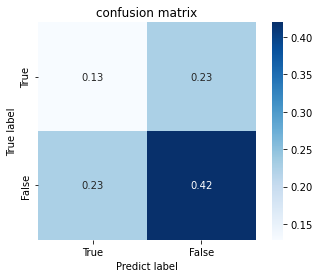

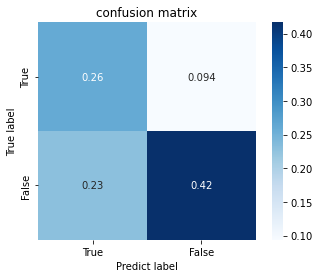

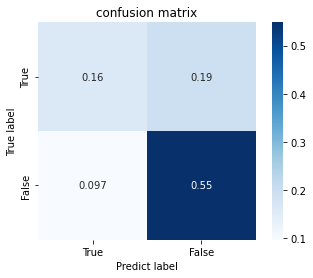

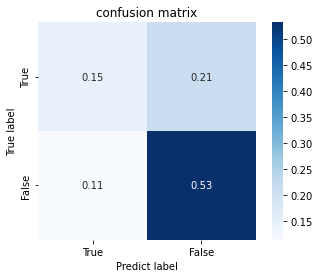

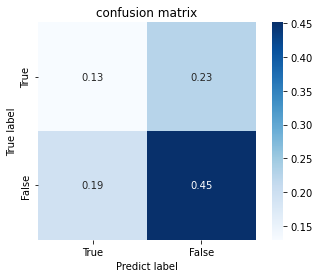

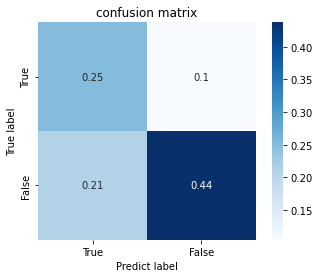

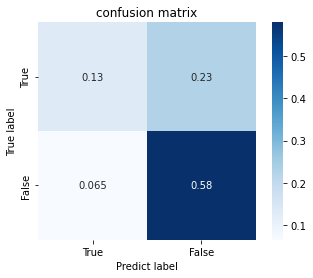

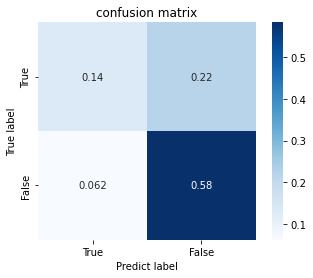

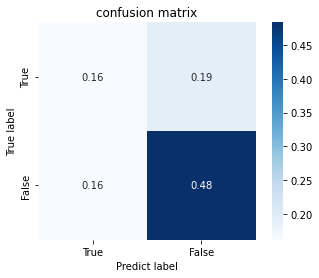

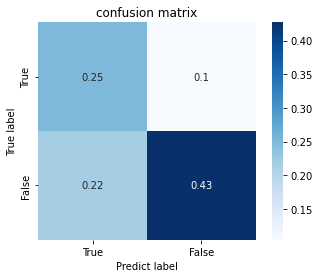

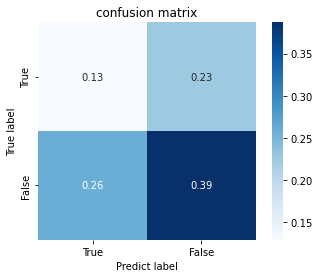

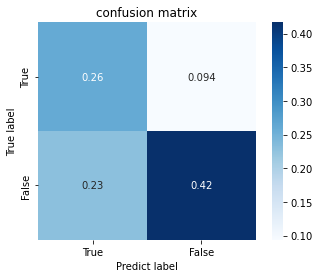

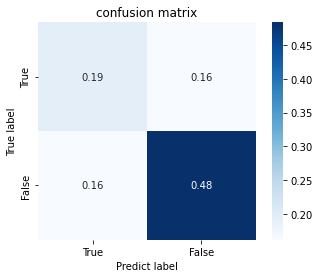

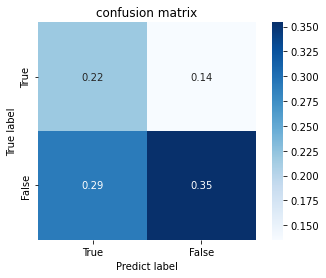

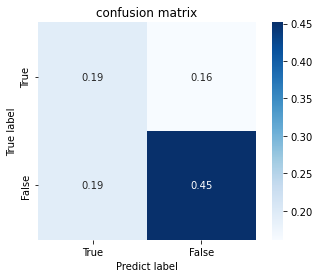

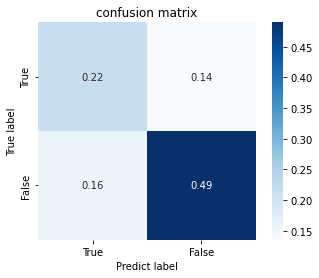

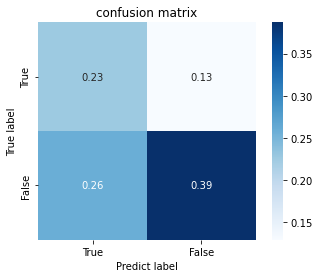

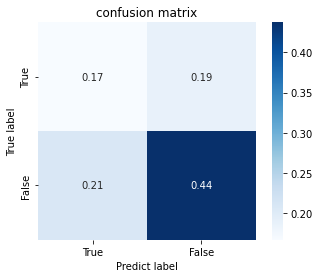

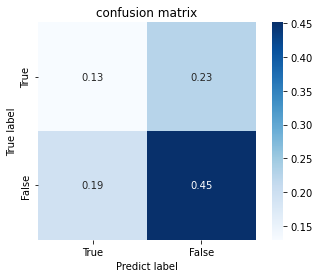

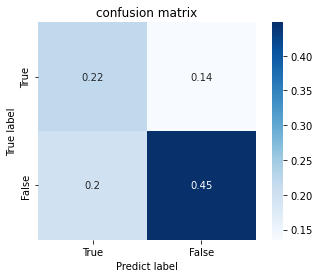

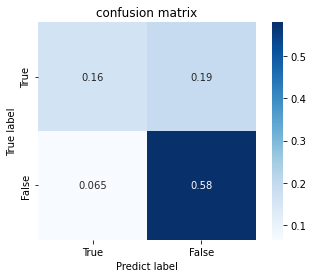

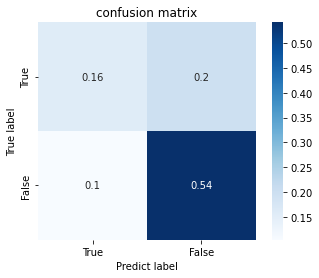

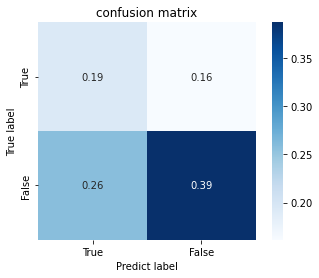

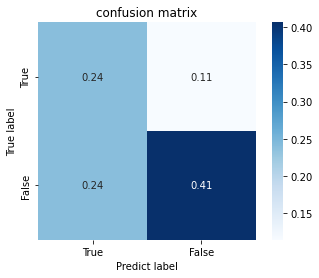

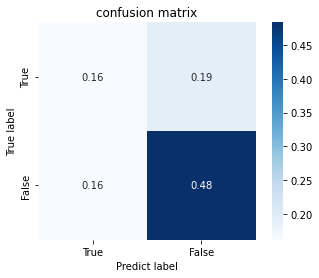

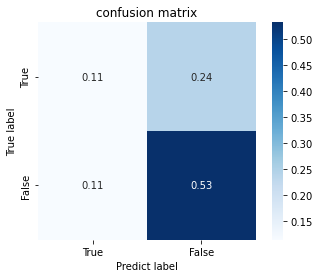

In [36]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "age"
method = "mrmr"


for clf in config.classifiers:

    print("=====" * 10)
    print(clf)

    validate_clf(
        microarray_type=microarray_type,
        cat_name=cat_name,
        method=method,
        clf=clf,
    )

--------------------------------------------------
[0, 50]


accuracy     0.774194
precision    0.833333
recall       0.454545
f1 score     0.588235
dtype: float64

--------------------------------------------------
[50, 100]


accuracy     0.666667
precision    0.545455
recall       0.352941
f1 score     0.428571
dtype: float64

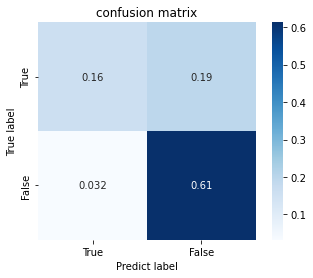

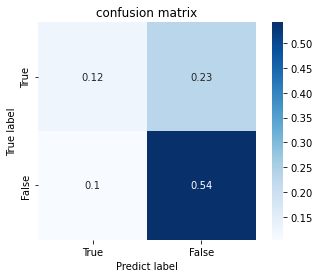

In [37]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "age"
method = "mrmr"

clf = LGBMClassifier()

validate_clf(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
    clf=clf,
)

# サブタイプと年齢データでの予測モデル検証

In [33]:
def do_compare_bcms(
    microarray_type: str,
    cat_name: str,
    method: str,
    sampling: str = None,
):

    subtypes = [
        "claudin-low",
        "LumA",
        "LumB",
        "Her2",
        "Normal",
        "Basal",
    ]
    thresholds_list = [[0, 50], [50, 100]]

    for subtype in subtypes:  # 遺伝子サブタイプ毎のループ
        for thresholds in thresholds_list:
            prognosis_Xlabel = "X{0}_{1}_{2}to{3}".format(
                config.THRESHOLD_YEAR, subtype, thresholds[0], thresholds[1]
            )
            prognosis_ylabel = "y{0}_{1}_{2}to{3}".format(
                config.THRESHOLD_YEAR, subtype, thresholds[0], thresholds[1]
            )
            # 説明変数、目的変数の定義
            X_train = X_dict[microarray_type][cat_name][method]["train"][
                prognosis_Xlabel
            ]
            y_train = y_dict[microarray_type][cat_name][method]["train"][
                prognosis_ylabel
            ]
            X_val = X_dict[microarray_type][cat_name][method]["val"][prognosis_Xlabel]
            y_val = y_dict[microarray_type][cat_name][method]["val"][prognosis_ylabel]

            if X_train.shape[0] < 50:
                continue

            # sampling
            if sampling == "sm":
                sm = SMOTE(random_state=SEED)
                X_train, y_train = sm.fit_resample(X_train, y_train)

            y_pred = clf.predict(X_val)
            print("-----" * 10)
            print(subtype)
            print(thresholds)
            display(compare_bcms(X_train, y_train, X_val, y_val))


microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "subtype_and_age"
method = "mrmr"
do_compare_bcms(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
)

--------------------------------------------------
claudin-low
[50, 100]


11it [00:00, 44.97it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
AdaBoost,1.000000,0.666667,1.000000,0.4
Linear SVM,1.000000,0.666667,1.000000,0.4
Logistic Regression,1.000000,0.666667,1.000000,0.4
Naive Bayes,0.974026,0.666667,0.960000,0.4
Nearest Neighbors,0.948052,0.666667,0.916667,0.4
Polynomial SVM,0.935065,0.666667,0.888889,0.4
RBF SVM,0.987013,0.666667,0.979592,0.4
Random Forest,0.961039,0.666667,0.941176,0.4
Sigmoid SVM,0.974026,0.666667,0.958333,0.4


--------------------------------------------------
LumA
[0, 50]


11it [00:00, 44.56it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
AdaBoost,1.000000,0.9,1.000000,0.0
Decision Tree,0.740741,0.2,0.461538,0.0
Linear SVM,1.000000,0.7,1.000000,0.0
Logistic Regression,1.000000,0.8,1.000000,0.0
Naive Bayes,0.987654,0.8,0.941176,0.0
Nearest Neighbors,0.950617,0.9,0.714286,0.0
Polynomial SVM,0.987654,0.9,0.941176,0.0
Quadratic Discriminant Analysis,1.000000,0.9,1.000000,0.0
RBF SVM,1.000000,0.8,1.000000,0.0


--------------------------------------------------
LumA
[50, 100]


11it [00:00, 31.59it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Quadratic Discriminant Analysis,1.000000,0.823529,1.000000,0.500000
AdaBoost,0.986577,0.705882,0.970588,0.444444
Logistic Regression,0.815436,0.647059,0.682081,0.400000
Sigmoid SVM,0.775168,0.647059,0.617143,0.400000
Linear SVM,0.832215,0.617647,0.715909,0.380952
RBF SVM,0.882550,0.617647,0.790419,0.380952
Polynomial SVM,0.946309,0.705882,0.888889,0.375000
Decision Tree,0.798658,0.500000,0.666667,0.370370
Random Forest,0.942953,0.764706,0.884354,0.333333


--------------------------------------------------
LumB
[50, 100]


11it [00:00, 34.28it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Naive Bayes,0.857143,0.678571,0.829268,0.666667
Decision Tree,0.816327,0.642857,0.786730,0.642857
Random Forest,0.926531,0.642857,0.913462,0.642857
AdaBoost,0.971429,0.607143,0.965854,0.592593
Polynomial SVM,0.922449,0.607143,0.906404,0.592593
RBF SVM,0.922449,0.607143,0.909091,0.592593
Quadratic Discriminant Analysis,1.000000,0.607143,1.000000,0.560000
Linear SVM,0.828571,0.535714,0.807339,0.551724
Logistic Regression,0.820408,0.535714,0.796296,0.551724


--------------------------------------------------
Her2
[50, 100]


11it [00:00, 42.66it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Random Forest,0.933962,0.833333,0.935780,0.800000
AdaBoost,1.000000,0.750000,1.000000,0.727273
Linear SVM,0.943396,0.750000,0.944444,0.727273
Logistic Regression,0.924528,0.750000,0.927273,0.727273
Naive Bayes,0.877358,0.750000,0.878505,0.727273
Nearest Neighbors,0.933962,0.750000,0.935780,0.727273
Quadratic Discriminant Analysis,1.000000,0.750000,1.000000,0.727273
RBF SVM,0.981132,0.750000,0.981818,0.727273
Sigmoid SVM,0.886792,0.750000,0.892857,0.727273


--------------------------------------------------
Normal
[50, 100]


11it [00:00, 47.64it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
AdaBoost,1.000000,0.333333,1.000000,0.0
Decision Tree,0.769231,0.333333,0.727273,0.0
Linear SVM,1.000000,0.500000,1.000000,0.0
Logistic Regression,1.000000,0.500000,1.000000,0.0
Naive Bayes,0.980769,0.500000,0.972973,0.0
Nearest Neighbors,0.942308,0.500000,0.909091,0.0
Polynomial SVM,1.000000,0.500000,1.000000,0.0
Quadratic Discriminant Analysis,1.000000,0.500000,1.000000,0.0
RBF SVM,1.000000,0.500000,1.000000,0.0


--------------------------------------------------
Basal
[0, 50]


11it [00:00, 47.16it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Naive Bayes,0.981481,0.857143,0.983051,0.857143
Polynomial SVM,0.907407,0.714286,0.920635,0.800000
AdaBoost,1.000000,0.714286,1.000000,0.750000
Random Forest,0.944444,0.714286,0.947368,0.750000
Decision Tree,0.814815,0.571429,0.791667,0.571429
Linear SVM,1.000000,0.428571,1.000000,0.500000
Logistic Regression,0.981481,0.428571,0.983051,0.500000
Nearest Neighbors,0.981481,0.428571,0.983051,0.500000
Quadratic Discriminant Analysis,1.000000,0.428571,1.000000,0.500000


--------------------------------------------------
Basal
[50, 100]


11it [00:00, 45.87it/s]


,acc_train,acc_val,f1_train,f1_val
classifier,,,,
Random Forest,0.890411,0.555556,0.878788,0.600000
Polynomial SVM,0.767123,0.333333,0.790123,0.500000
Linear SVM,0.986301,0.444444,0.984615,0.444444
Logistic Regression,1.000000,0.444444,1.000000,0.444444
Nearest Neighbors,0.945205,0.333333,0.939394,0.400000
Sigmoid SVM,0.958904,0.333333,0.955224,0.400000
Naive Bayes,0.876712,0.222222,0.876712,0.363636
Decision Tree,0.753425,0.444444,0.735294,0.285714
AdaBoost,1.000000,0.333333,1.000000,0.250000


In [34]:
def validate_clf(
    microarray_type: str,
    cat_name: str,
    method: str,
    clf: callable,
    clf_params: dict() = None,
    sampling: str = None,
):

    subtypes = [
        "claudin-low",
        "LumA",
        "LumB",
        "Her2",
        "Normal",
        "Basal",
    ]
    thresholds_list = [[0, 50], [50, 100]]

    for subtype in subtypes:  # 遺伝子サブタイプ毎のループ
        for thresholds in thresholds_list:
            prognosis_Xlabel = "X{0}_{1}_{2}to{3}".format(
                config.THRESHOLD_YEAR, subtype, thresholds[0], thresholds[1]
            )
            prognosis_ylabel = "y{0}_{1}_{2}to{3}".format(
                config.THRESHOLD_YEAR, subtype, thresholds[0], thresholds[1]
            )
            # 説明変数、目的変数の定義
            X_train = X_dict[microarray_type][cat_name][method]["train"][
                prognosis_Xlabel
            ]
            y_train = y_dict[microarray_type][cat_name][method]["train"][
                prognosis_ylabel
            ]
            X_val = X_dict[microarray_type][cat_name][method]["val"][prognosis_Xlabel]
            y_val = y_dict[microarray_type][cat_name][method]["val"][prognosis_ylabel]

            if X_train.shape[0] < 50:
                continue

            # sampling
            if sampling == "sm":
                sm = SMOTE(random_state=SEED)
                X_train, y_train = sm.fit_resample(X_train, y_train)

            if clf_params:
                clf.set_params(**clf_params)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            print("-----" * 10)
            print(subtype)
            print(thresholds)
            show_scores(y_val, y_pred)
            plot_confusion_matrix(y_val, y_pred)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=100)
--------------------------------------------------
claudin-low
[50, 100]


accuracy     0.666667
precision    0.500000
recall       0.333333
f1 score     0.400000
dtype: float64

--------------------------------------------------
LumA
[0, 50]


accuracy     0.8
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
LumA
[50, 100]


accuracy     0.647059
precision    0.333333
recall       0.500000
f1 score     0.400000
dtype: float64

--------------------------------------------------
LumB
[50, 100]


accuracy     0.500000
precision    0.437500
recall       0.583333
f1 score     0.500000
dtype: float64

--------------------------------------------------
Her2
[50, 100]


accuracy     0.750000
precision    0.800000
recall       0.666667
f1 score     0.727273
dtype: float64

--------------------------------------------------
Normal
[50, 100]


accuracy     0.5
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
Basal
[0, 50]


accuracy     0.428571
precision    0.500000
recall       0.500000
f1 score     0.500000
dtype: float64

--------------------------------------------------
Basal
[50, 100]


accuracy     0.444444
precision    0.400000
recall       0.500000
f1 score     0.444444
dtype: float64

KNeighborsClassifier()
--------------------------------------------------
claudin-low
[50, 100]


accuracy     0.555556
precision    0.333333
recall       0.333333
f1 score     0.333333
dtype: float64

--------------------------------------------------
LumA
[0, 50]


accuracy     0.7
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
LumA
[50, 100]


accuracy     0.529412
precision    0.277778
recall       0.625000
f1 score     0.384615
dtype: float64

--------------------------------------------------
LumB
[50, 100]


accuracy     0.500000
precision    0.437500
recall       0.583333
f1 score     0.500000
dtype: float64

--------------------------------------------------
Her2
[50, 100]


accuracy     0.666667
precision    0.750000
recall       0.500000
f1 score     0.600000
dtype: float64

--------------------------------------------------
Normal
[50, 100]


accuracy     0.5
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
Basal
[0, 50]


accuracy     0.428571
precision    0.500000
recall       0.500000
f1 score     0.500000
dtype: float64

--------------------------------------------------
Basal
[50, 100]


accuracy     0.222222
precision    0.285714
recall       0.500000
f1 score     0.363636
dtype: float64

SVC(class_weight='balanced', kernel='linear', random_state=100)
--------------------------------------------------
claudin-low
[50, 100]


accuracy     0.666667
precision    0.500000
recall       0.333333
f1 score     0.400000
dtype: float64

--------------------------------------------------
LumA
[0, 50]


accuracy     0.7
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
LumA
[50, 100]


accuracy     0.617647
precision    0.307692
recall       0.500000
f1 score     0.380952
dtype: float64

--------------------------------------------------
LumB
[50, 100]


accuracy     0.464286
precision    0.421053
recall       0.666667
f1 score     0.516129
dtype: float64

--------------------------------------------------
Her2
[50, 100]


accuracy     0.750000
precision    0.800000
recall       0.666667
f1 score     0.727273
dtype: float64

--------------------------------------------------
Normal
[50, 100]


accuracy     0.5
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
Basal
[0, 50]


accuracy     0.428571
precision    0.500000
recall       0.500000
f1 score     0.500000
dtype: float64

--------------------------------------------------
Basal
[50, 100]


accuracy     0.444444
precision    0.400000
recall       0.500000
f1 score     0.444444
dtype: float64

SVC(class_weight='balanced', kernel='poly', random_state=100)
--------------------------------------------------
claudin-low
[50, 100]


accuracy     0.666667
precision    0.500000
recall       0.333333
f1 score     0.400000
dtype: float64

--------------------------------------------------
LumA
[0, 50]


accuracy     0.9
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
LumA
[50, 100]


accuracy     0.647059
precision    0.300000
recall       0.375000
f1 score     0.333333
dtype: float64

--------------------------------------------------
LumB
[50, 100]


accuracy     0.500000
precision    0.444444
recall       0.666667
f1 score     0.533333
dtype: float64

--------------------------------------------------
Her2
[50, 100]


accuracy     0.583333
precision    0.571429
recall       0.666667
f1 score     0.615385
dtype: float64

--------------------------------------------------
Normal
[50, 100]


accuracy     0.5
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
Basal
[0, 50]


accuracy     0.714286
precision    0.666667
recall       1.000000
f1 score     0.800000
dtype: float64

--------------------------------------------------
Basal
[50, 100]


accuracy     0.333333
precision    0.375000
recall       0.750000
f1 score     0.500000
dtype: float64

SVC(class_weight='balanced', random_state=100)
--------------------------------------------------
claudin-low
[50, 100]


accuracy     0.666667
precision    0.500000
recall       0.333333
f1 score     0.400000
dtype: float64

--------------------------------------------------
LumA
[0, 50]


accuracy     0.8
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
LumA
[50, 100]


accuracy     0.617647
precision    0.272727
recall       0.375000
f1 score     0.315789
dtype: float64

--------------------------------------------------
LumB
[50, 100]


accuracy     0.535714
precision    0.461538
recall       0.500000
f1 score     0.480000
dtype: float64

--------------------------------------------------
Her2
[50, 100]


accuracy     0.750000
precision    0.800000
recall       0.666667
f1 score     0.727273
dtype: float64

--------------------------------------------------
Normal
[50, 100]


accuracy     0.5
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
Basal
[0, 50]


accuracy     0.428571
precision    0.500000
recall       0.500000
f1 score     0.500000
dtype: float64

--------------------------------------------------
Basal
[50, 100]


accuracy     0.111111
precision    0.166667
recall       0.250000
f1 score     0.200000
dtype: float64

SVC(class_weight='balanced', kernel='sigmoid', random_state=100)
--------------------------------------------------
claudin-low
[50, 100]


accuracy     0.666667
precision    0.500000
recall       0.333333
f1 score     0.400000
dtype: float64

--------------------------------------------------
LumA
[0, 50]


accuracy     0.5
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
LumA
[50, 100]


accuracy     0.647059
precision    0.357143
recall       0.625000
f1 score     0.454545
dtype: float64

--------------------------------------------------
LumB
[50, 100]


accuracy     0.500000
precision    0.437500
recall       0.583333
f1 score     0.500000
dtype: float64

--------------------------------------------------
Her2
[50, 100]


accuracy     0.750000
precision    0.800000
recall       0.666667
f1 score     0.727273
dtype: float64

--------------------------------------------------
Normal
[50, 100]


accuracy     0.5
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
Basal
[0, 50]


accuracy     0.571429
precision    0.666667
recall       0.500000
f1 score     0.571429
dtype: float64

--------------------------------------------------
Basal
[50, 100]


accuracy     0.333333
precision    0.333333
recall       0.500000
f1 score     0.400000
dtype: float64

DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=15,
                       min_samples_split=20, random_state=100)
--------------------------------------------------
claudin-low
[50, 100]


accuracy     0.555556
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
LumA
[0, 50]


accuracy     0.7
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
LumA
[50, 100]


accuracy     0.470588
precision    0.142857
recall       0.250000
f1 score     0.181818
dtype: float64

--------------------------------------------------
LumB
[50, 100]


accuracy     0.571429
precision    0.500000
recall       0.500000
f1 score     0.500000
dtype: float64

--------------------------------------------------
Her2
[50, 100]


accuracy     0.750000
precision    1.000000
recall       0.500000
f1 score     0.666667
dtype: float64

--------------------------------------------------
Normal
[50, 100]


accuracy     0.5
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
Basal
[0, 50]


accuracy     0.571429
precision    0.666667
recall       0.500000
f1 score     0.571429
dtype: float64

--------------------------------------------------
Basal
[50, 100]


accuracy     0.555556
precision    0.500000
recall       0.250000
f1 score     0.333333
dtype: float64

RandomForestClassifier(class_weight='balanced', min_samples_leaf=15,
                       min_samples_split=20, random_state=100)
--------------------------------------------------
claudin-low
[50, 100]


accuracy     0.555556
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
LumA
[0, 50]


accuracy     0.8
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
LumA
[50, 100]


accuracy     0.705882
precision    0.375000
recall       0.375000
f1 score     0.375000
dtype: float64

--------------------------------------------------
LumB
[50, 100]


accuracy     0.678571
precision    0.600000
recall       0.750000
f1 score     0.666667
dtype: float64

--------------------------------------------------
Her2
[50, 100]


accuracy     0.833333
precision    1.000000
recall       0.666667
f1 score     0.800000
dtype: float64

--------------------------------------------------
Normal
[50, 100]


accuracy     0.5
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
Basal
[0, 50]


accuracy     0.571429
precision    0.666667
recall       0.500000
f1 score     0.571429
dtype: float64

--------------------------------------------------
Basal
[50, 100]


accuracy     0.444444
precision    0.400000
recall       0.500000
f1 score     0.444444
dtype: float64

AdaBoostClassifier(random_state=100)
--------------------------------------------------
claudin-low
[50, 100]


accuracy     0.666667
precision    0.500000
recall       0.333333
f1 score     0.400000
dtype: float64

--------------------------------------------------
LumA
[0, 50]


accuracy     0.9
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
LumA
[50, 100]


accuracy     0.647059
precision    0.250000
recall       0.250000
f1 score     0.250000
dtype: float64

--------------------------------------------------
LumB
[50, 100]


accuracy     0.642857
precision    0.571429
recall       0.666667
f1 score     0.615385
dtype: float64

--------------------------------------------------
Her2
[50, 100]


accuracy     0.833333
precision    1.000000
recall       0.666667
f1 score     0.800000
dtype: float64

--------------------------------------------------
Normal
[50, 100]


accuracy     0.333333
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
Basal
[0, 50]


accuracy     0.428571
precision    0.500000
recall       0.250000
f1 score     0.333333
dtype: float64

--------------------------------------------------
Basal
[50, 100]


accuracy     0.333333
precision    0.250000
recall       0.250000
f1 score     0.250000
dtype: float64

GaussianNB()
--------------------------------------------------
claudin-low
[50, 100]


accuracy     0.666667
precision    0.500000
recall       0.333333
f1 score     0.400000
dtype: float64

--------------------------------------------------
LumA
[0, 50]


accuracy     0.8
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
LumA
[50, 100]


accuracy     0.588235
precision    0.285714
recall       0.500000
f1 score     0.363636
dtype: float64

--------------------------------------------------
LumB
[50, 100]


accuracy     0.642857
precision    0.571429
recall       0.666667
f1 score     0.615385
dtype: float64

--------------------------------------------------
Her2
[50, 100]


accuracy     0.750000
precision    0.800000
recall       0.666667
f1 score     0.727273
dtype: float64

--------------------------------------------------
Normal
[50, 100]


accuracy     0.5
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
Basal
[0, 50]


accuracy     0.857143
precision    1.000000
recall       0.750000
f1 score     0.857143
dtype: float64

--------------------------------------------------
Basal
[50, 100]


accuracy     0.222222
precision    0.285714
recall       0.500000
f1 score     0.363636
dtype: float64

GradientBoostingClassifier(random_state=100)
--------------------------------------------------
claudin-low
[50, 100]


accuracy     0.666667
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
LumA
[0, 50]


accuracy     0.5
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
LumA
[50, 100]


accuracy     0.705882
precision    0.375000
recall       0.375000
f1 score     0.375000
dtype: float64

--------------------------------------------------
LumB
[50, 100]


accuracy     0.607143
precision    0.533333
recall       0.666667
f1 score     0.592593
dtype: float64

--------------------------------------------------
Her2
[50, 100]


accuracy     0.750000
precision    0.800000
recall       0.666667
f1 score     0.727273
dtype: float64

--------------------------------------------------
Normal
[50, 100]


accuracy     0.666667
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
Basal
[0, 50]


accuracy     0.428571
precision    0.500000
recall       0.500000
f1 score     0.500000
dtype: float64

--------------------------------------------------
Basal
[50, 100]


accuracy     0.222222
precision    0.200000
recall       0.250000
f1 score     0.222222
dtype: float64

SGDClassifier(class_weight='balanced', random_state=100)
--------------------------------------------------
claudin-low
[50, 100]


accuracy     0.555556
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
LumA
[0, 50]


accuracy     0.9
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
LumA
[50, 100]


accuracy     0.558824
precision    0.266667
recall       0.500000
f1 score     0.347826
dtype: float64

--------------------------------------------------
LumB
[50, 100]


accuracy     0.607143
precision    0.533333
recall       0.666667
f1 score     0.592593
dtype: float64

--------------------------------------------------
Her2
[50, 100]


accuracy     0.666667
precision    0.750000
recall       0.500000
f1 score     0.600000
dtype: float64

--------------------------------------------------
Normal
[50, 100]


accuracy     0.333333
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
Basal
[0, 50]


accuracy     0.571429
precision    0.666667
recall       0.500000
f1 score     0.571429
dtype: float64

--------------------------------------------------
Basal
[50, 100]


accuracy     0.444444
precision    0.400000
recall       0.500000
f1 score     0.444444
dtype: float64

QuadraticDiscriminantAnalysis()
--------------------------------------------------
claudin-low
[50, 100]


accuracy     0.666667
precision    0.500000
recall       0.333333
f1 score     0.400000
dtype: float64

--------------------------------------------------
LumA
[0, 50]


accuracy     0.9
precision    0.0
recall       0.0
f1 score     0.0
dtype: float64

--------------------------------------------------
LumA
[50, 100]


accuracy     0.558824
precision    0.230769
recall       0.375000
f1 score     0.285714
dtype: float64

--------------------------------------------------
LumB
[50, 100]


accuracy     0.500000
precision    0.437500
recall       0.583333
f1 score     0.500000
dtype: float64

--------------------------------------------------
Her2
[50, 100]


accuracy     0.666667
precision    0.750000
recall       0.500000
f1 score     0.600000
dtype: float64

--------------------------------------------------
Normal
[50, 100]


accuracy     0.666667
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
Basal
[0, 50]


accuracy     0.428571
precision    0.500000
recall       0.500000
f1 score     0.500000
dtype: float64

--------------------------------------------------
Basal
[50, 100]


accuracy     0.222222
precision    0.200000
recall       0.250000
f1 score     0.222222
dtype: float64

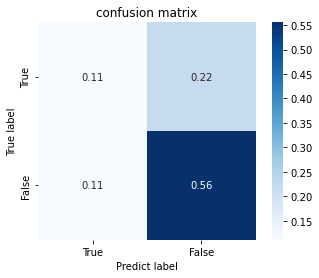

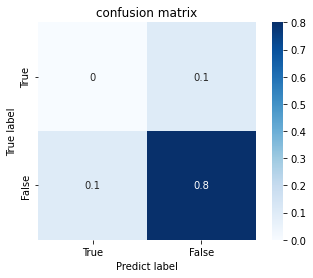

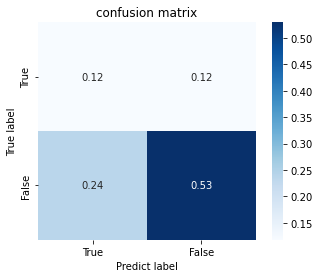

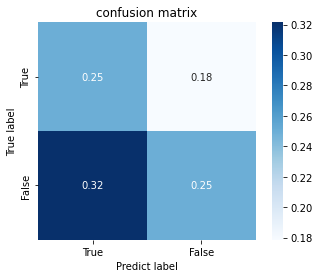

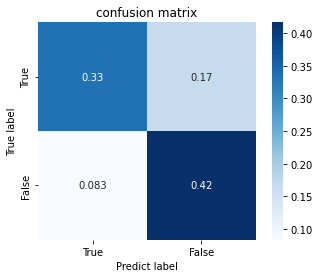

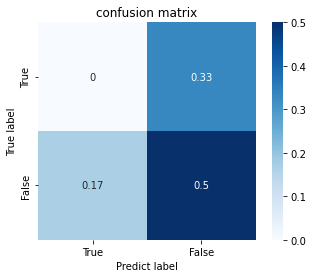

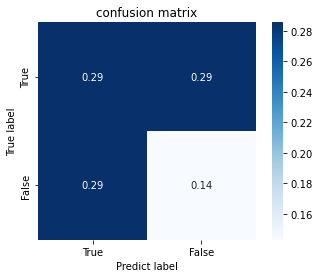

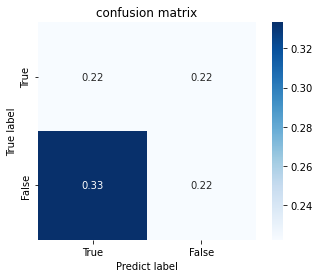

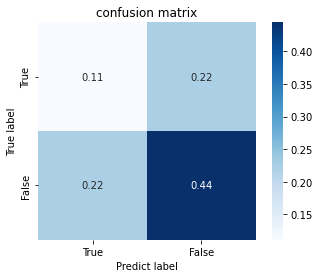

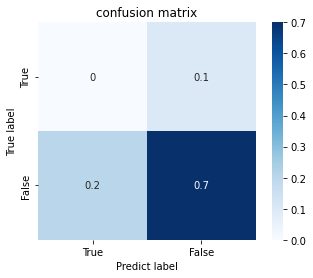

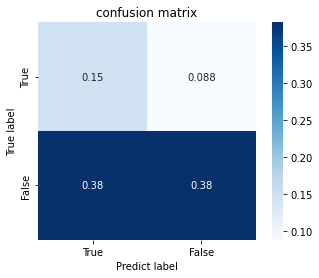

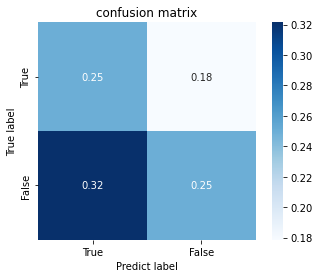

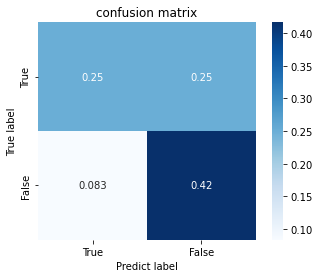

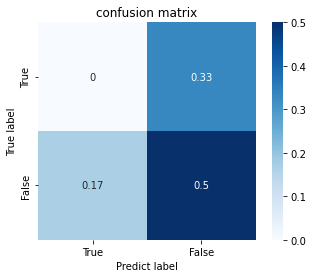

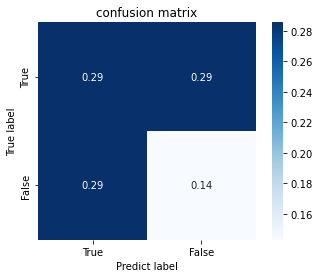

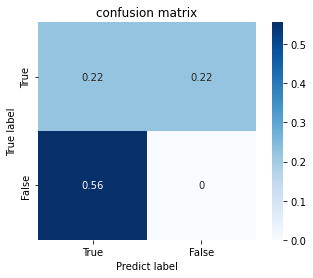

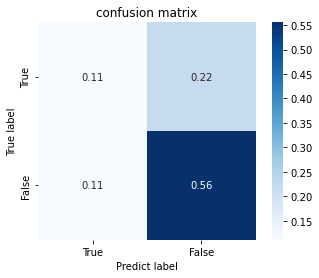

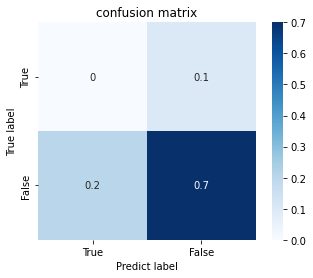

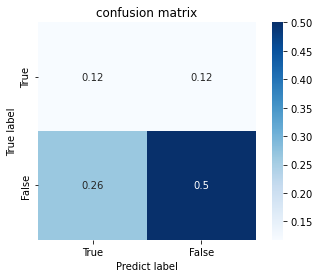

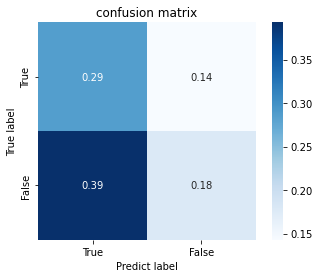

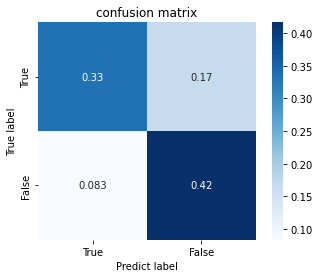

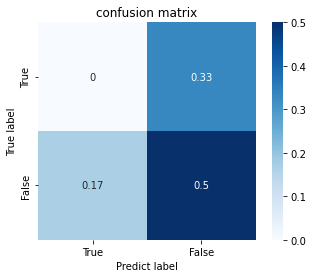

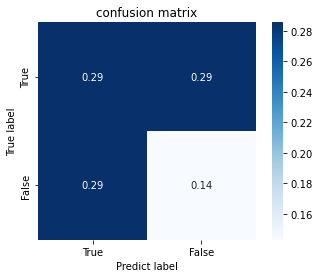

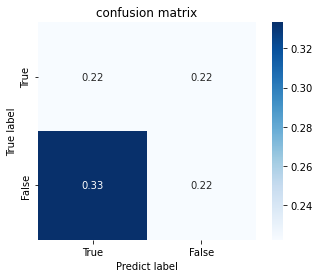

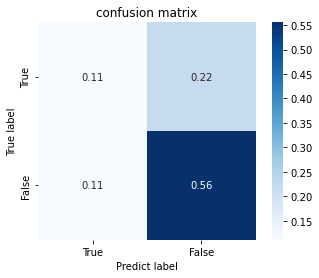

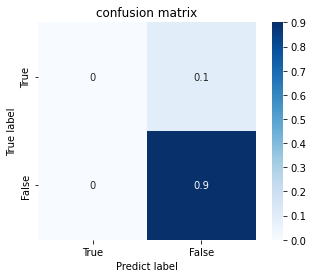

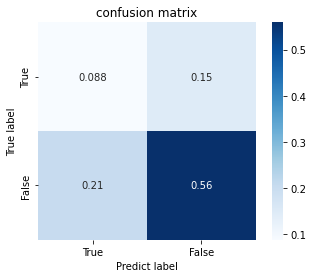

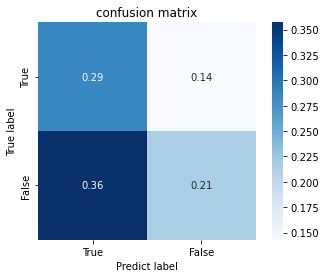

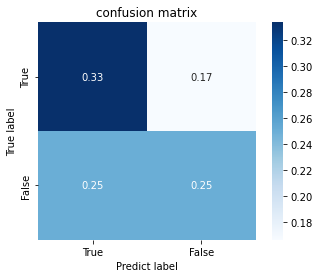

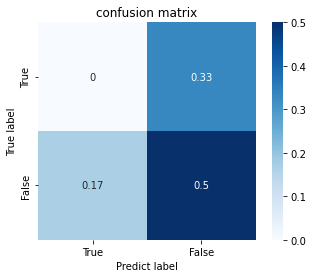

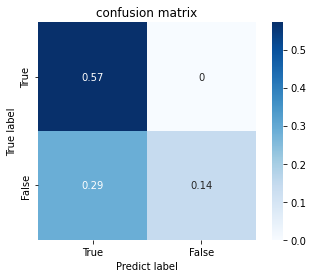

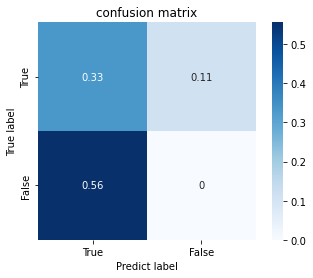

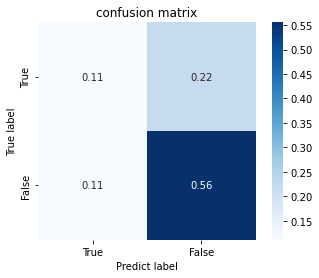

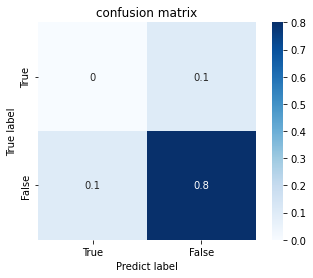

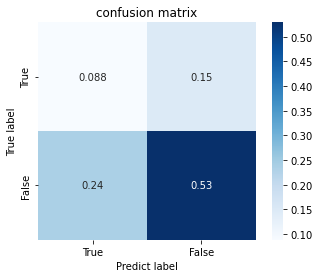

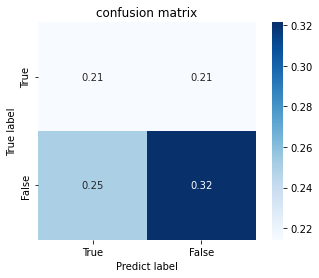

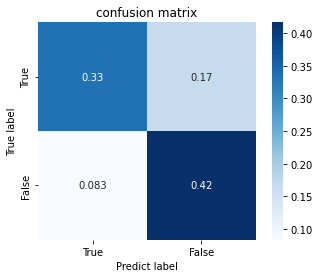

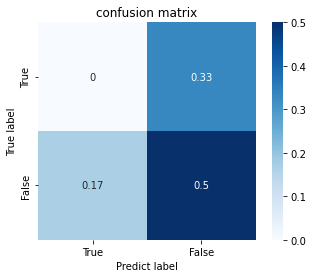

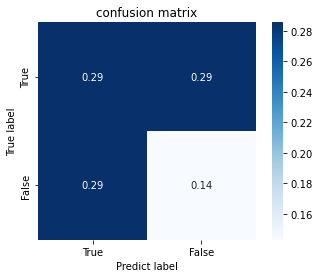

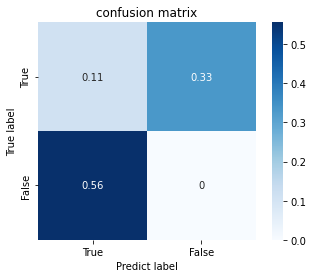

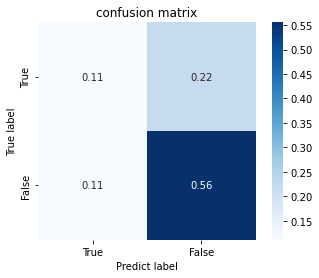

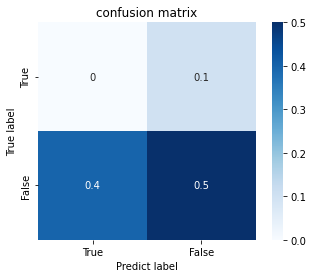

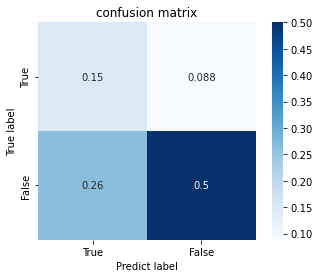

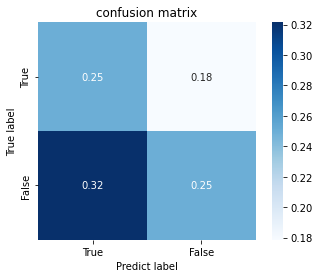

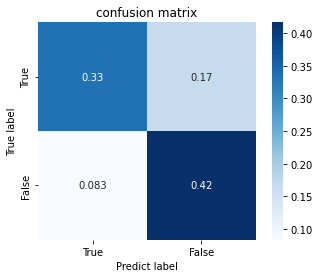

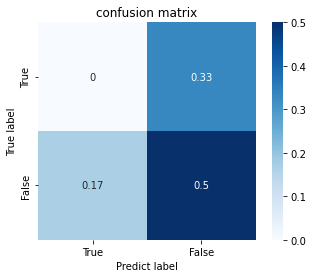

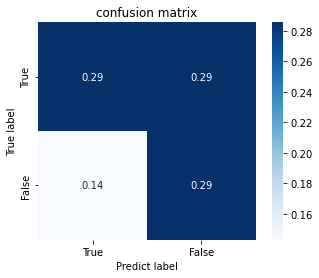

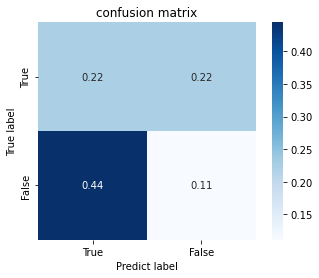

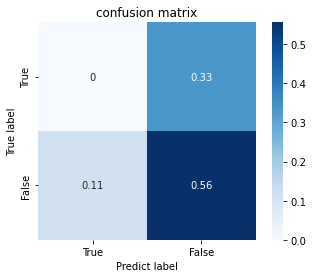

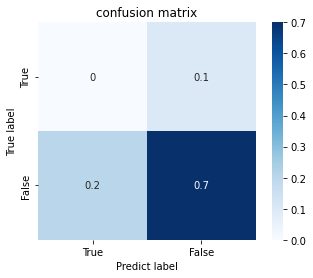

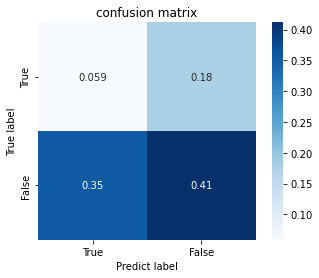

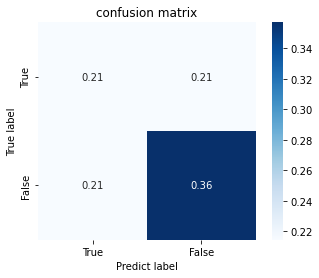

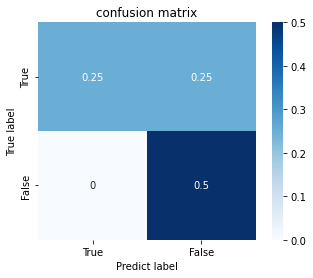

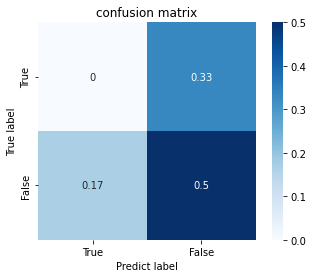

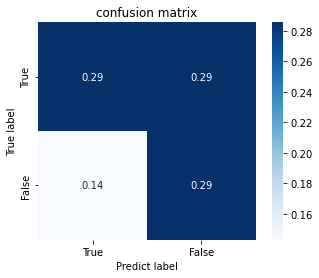

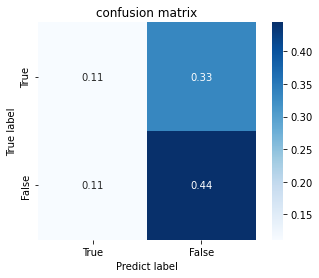

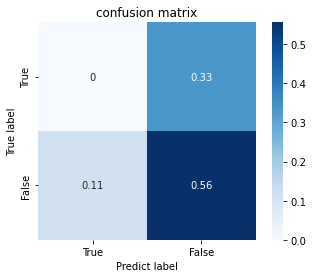

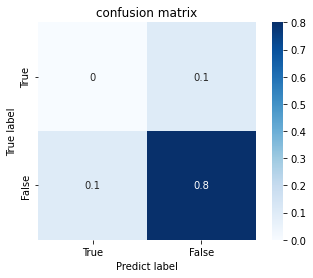

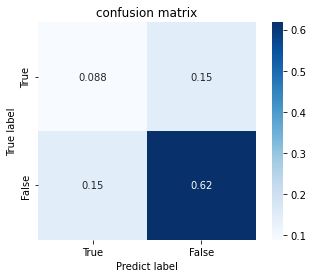

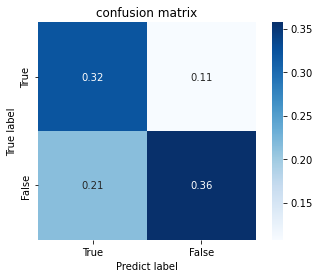

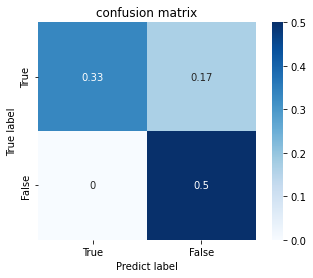

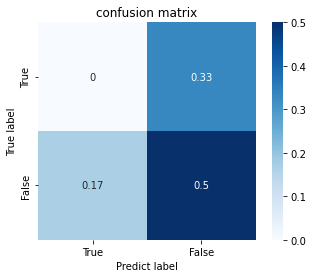

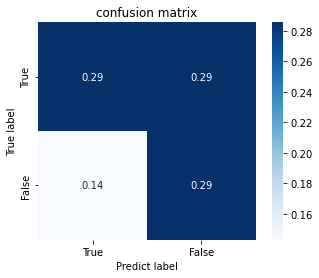

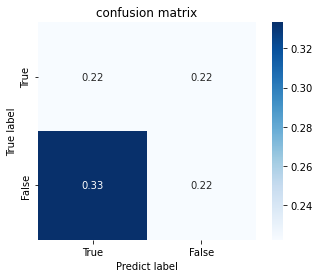

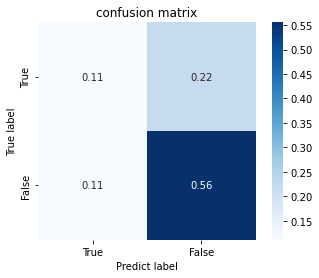

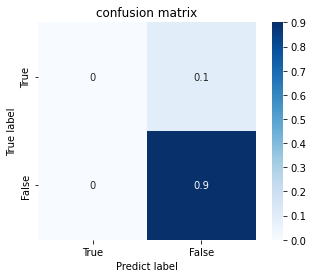

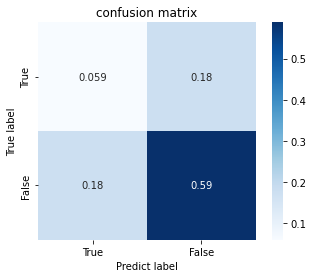

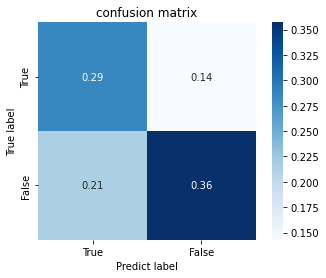

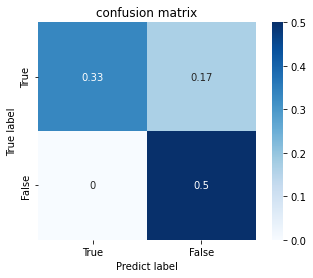

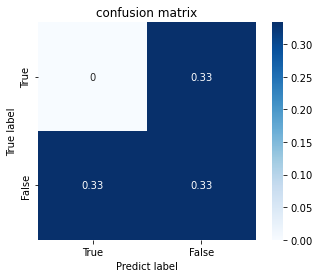

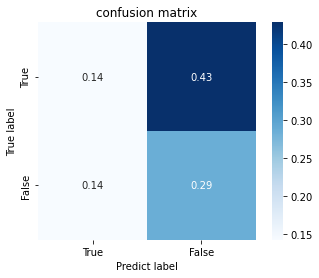

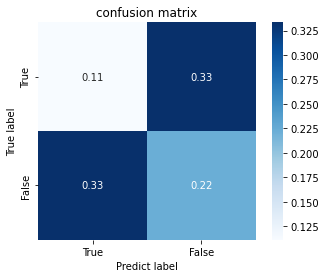

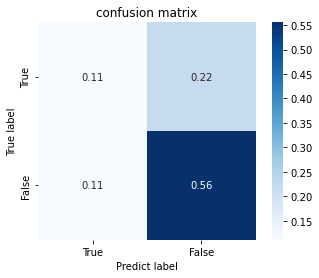

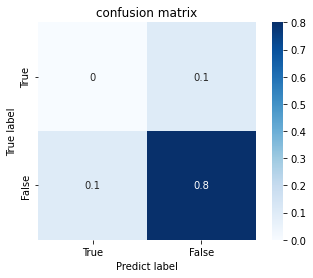

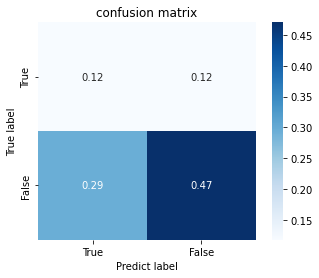

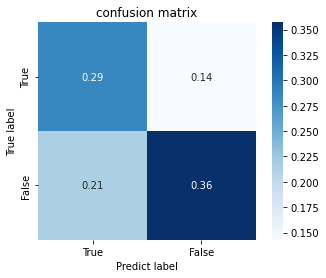

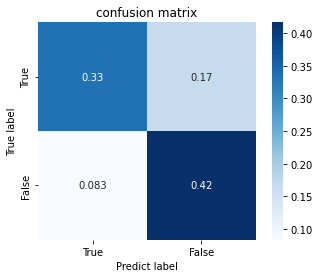

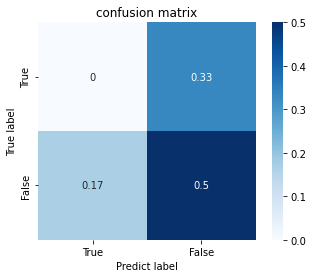

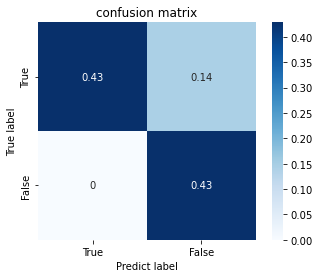

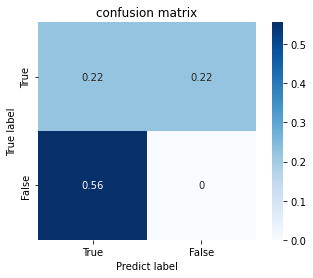

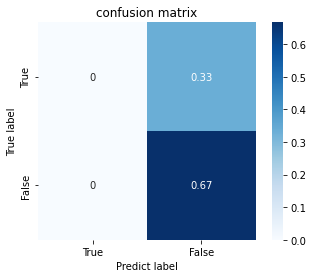

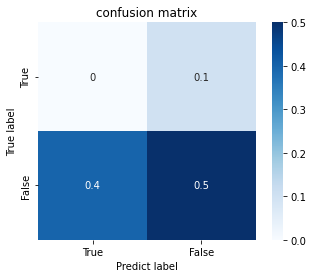

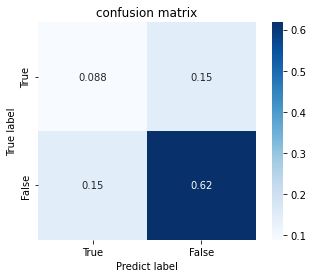

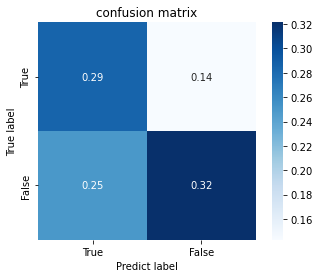

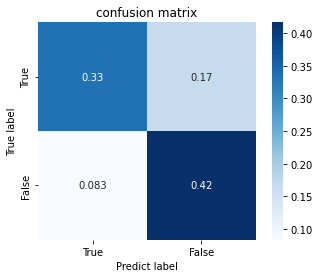

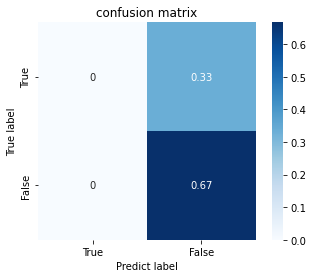

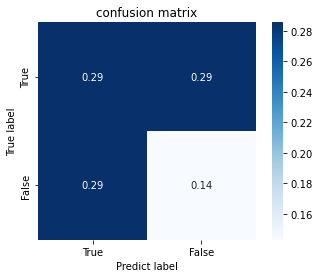

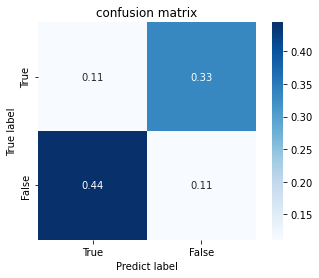

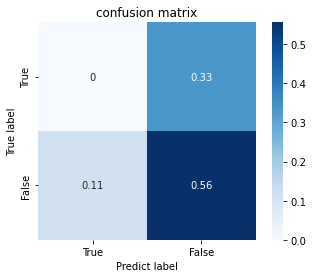

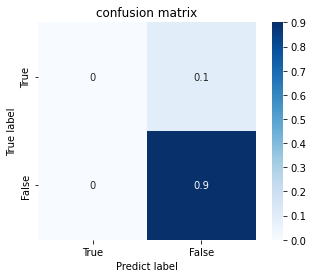

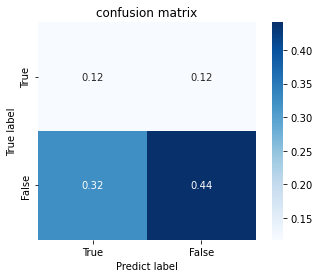

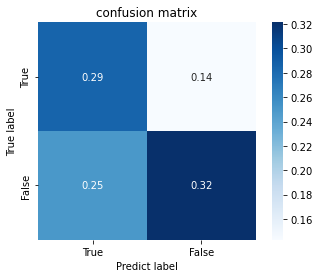

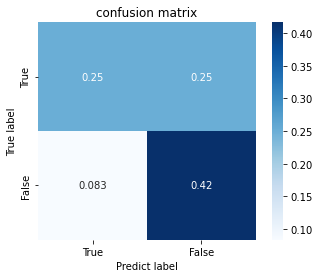

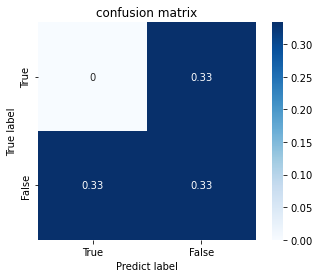

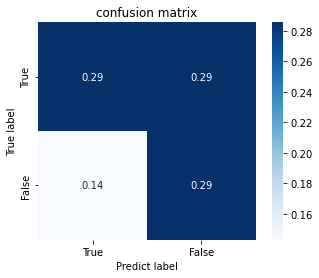

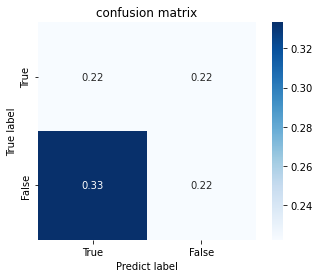

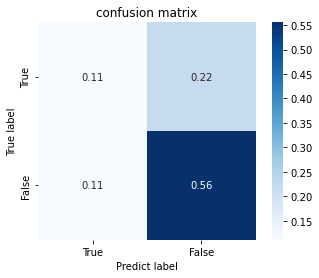

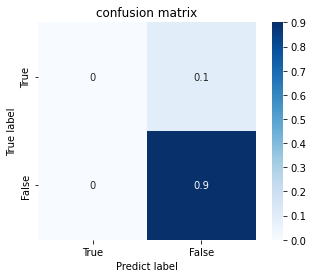

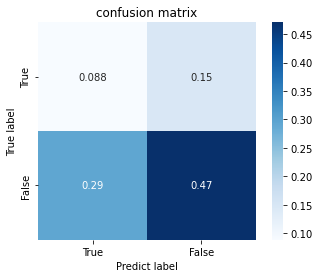

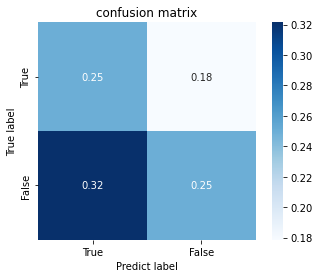

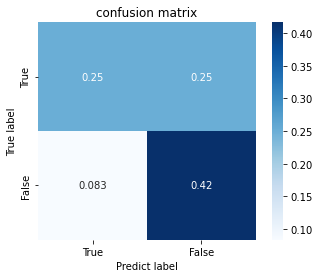

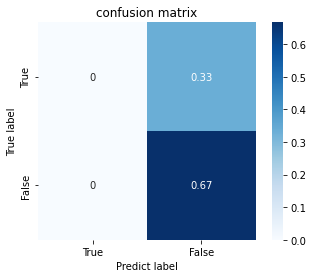

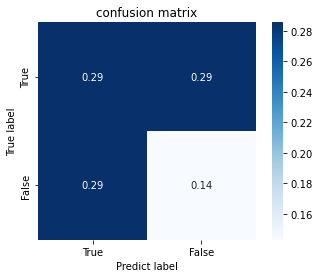

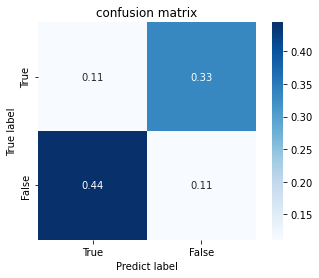

In [26]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "subtype_and_age"
method = "mrmr"


for clf in config.classifiers:

    print("=====" * 10)
    print(clf)

    validate_clf(
        microarray_type=microarray_type,
        cat_name=cat_name,
        method=method,
        clf=clf,
        sampling="sm",
    )

### LightGBM

In [28]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "subtype_and_age"
method = "mrmr"

clf = LGBMClassifier()
clf_params = {
    "class_weight": "balanced",
    "random_state": SEED,
}

validate_clf(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
    clf=clf,
    clf_params=clf_params,
)

--------------------------------------------------
[55, 100]
claudin-low


accuracy     0.714286
precision    0.500000
recall       1.000000
f1 score     0.666667
dtype: float64

--------------------------------------------------
[45, 55]
LumA


accuracy     0.909091
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
[55, 100]
LumA


accuracy     0.714286
precision    0.428571
recall       0.428571
f1 score     0.428571
dtype: float64

--------------------------------------------------
[55, 100]
LumB


accuracy     0.346154
precision    0.125000
recall       0.090909
f1 score     0.105263
dtype: float64

--------------------------------------------------
[55, 100]
Her2


accuracy     0.4
precision    0.4
recall       0.4
f1 score     0.4
dtype: float64

--------------------------------------------------
[55, 100]
Basal


accuracy     0.571429
precision    0.500000
recall       0.666667
f1 score     0.571429
dtype: float64

### SVM

In [25]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "subtype_and_age"
method = "mrmr"

clf = SVC()
clf_params = {
    "kernel": "poly",
    "class_weight": "balanced",
    "random_state": SEED,
}

validate_clf(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
    clf=clf,
    clf_params=clf_params,
)

--------------------------------------------------
[55, 100]
claudin-low


accuracy     0.571429
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
[45, 55]
LumA


accuracy     0.909091
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
[55, 100]
LumA


accuracy     0.678571
precision    0.250000
recall       0.142857
f1 score     0.181818
dtype: float64

--------------------------------------------------
[55, 100]
LumB


accuracy     0.423077
precision    0.300000
recall       0.272727
f1 score     0.285714
dtype: float64

--------------------------------------------------
[55, 100]
Her2


accuracy     0.500000
precision    0.500000
recall       0.400000
f1 score     0.444444
dtype: float64

--------------------------------------------------
[55, 100]
Basal


accuracy     0.714286
precision    0.600000
recall       1.000000
f1 score     0.750000
dtype: float64

In [31]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "subtype_and_age"
method = "mrmr"

clf = SVC()
clf_params = {
    "kernel": "poly",
    "C": 0.0001,
    "class_weight": "balanced",
    "random_state": SEED,
}

validate_clf(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
    clf=clf,
    clf_params=clf_params,
)

--------------------------------------------------
[55, 100]
claudin-low


accuracy     0.714286
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
[45, 55]
LumA


accuracy     0.909091
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
[55, 100]
LumA


accuracy     0.25
precision    0.25
recall       1.00
f1 score     0.40
dtype: float64

--------------------------------------------------
[55, 100]
LumB


accuracy     0.423077
precision    0.423077
recall       1.000000
f1 score     0.594595
dtype: float64

--------------------------------------------------
[55, 100]
Her2


accuracy     0.500000
precision    0.500000
recall       1.000000
f1 score     0.666667
dtype: float64

--------------------------------------------------
[55, 100]
Basal


accuracy     0.428571
precision    0.428571
recall       1.000000
f1 score     0.600000
dtype: float64

### RandomForest

In [37]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "subtype_and_age"
method = "mrmr"

clf = RandomForestClassifier()
clf_params = {
    "min_samples_split": 20,
    "min_samples_leaf": 15,
    "class_weight": "balanced",
    "random_state": SEED,
}

validate_clf(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
    clf=clf,
    clf_params=clf_params,
)

--------------------------------------------------
[55, 100]
claudin-low


accuracy     0.428571
precision    0.250000
recall       0.500000
f1 score     0.333333
dtype: float64

--------------------------------------------------
[45, 55]
LumA


accuracy     0.909091
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
[55, 100]
LumA


accuracy     0.714286
precision    0.444444
recall       0.571429
f1 score     0.500000
dtype: float64

--------------------------------------------------
[55, 100]
LumB


accuracy     0.384615
precision    0.222222
recall       0.181818
f1 score     0.200000
dtype: float64

--------------------------------------------------
[55, 100]
Her2


accuracy     0.4
precision    0.4
recall       0.4
f1 score     0.4
dtype: float64

--------------------------------------------------
[55, 100]
Basal


accuracy     0.857143
precision    1.000000
recall       0.666667
f1 score     0.800000
dtype: float64

### Logistic Regression

In [44]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "subtype_and_age"
method = "mrmr"

clf = LogisticRegression()
clf_params = {
    "penalty": "l2",
    "solver": "liblinear",
    "class_weight": "balanced",
    "random_state": SEED,
}

validate_clf(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
    clf=clf,
    clf_params=clf_params,
)

--------------------------------------------------
[55, 100]
claudin-low


accuracy     0.285714
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
[45, 55]
LumA


accuracy     0.818182
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
[55, 100]
LumA


accuracy     0.642857
precision    0.285714
recall       0.285714
f1 score     0.285714
dtype: float64

--------------------------------------------------
[55, 100]
LumB


accuracy     0.423077
precision    0.300000
recall       0.272727
f1 score     0.285714
dtype: float64

--------------------------------------------------
[55, 100]
Her2


accuracy     0.500000
precision    0.500000
recall       0.400000
f1 score     0.444444
dtype: float64

--------------------------------------------------
[55, 100]
Basal


accuracy     0.714286
precision    0.666667
recall       0.666667
f1 score     0.666667
dtype: float64

In [52]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "subtype_and_age"
method = "mrmr"

clf = LogisticRegression()
clf_params = {
    "penalty": "l2",
    "solver": "liblinear",
    "C": 1000,
    "class_weight": "balanced",
    "random_state": SEED,
}

validate_clf(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
    clf=clf,
    clf_params=clf_params,
)

--------------------------------------------------
[55, 100]
claudin-low


accuracy     0.285714
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
[45, 55]
LumA


accuracy     0.909091
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
[55, 100]
LumA


accuracy     0.678571
precision    0.333333
recall       0.285714
f1 score     0.307692
dtype: float64

--------------------------------------------------
[55, 100]
LumB


accuracy     0.423077
precision    0.300000
recall       0.272727
f1 score     0.285714
dtype: float64

--------------------------------------------------
[55, 100]
Her2


accuracy     0.500000
precision    0.500000
recall       0.400000
f1 score     0.444444
dtype: float64

--------------------------------------------------
[55, 100]
Basal


accuracy     0.714286
precision    0.666667
recall       0.666667
f1 score     0.666667
dtype: float64

In [53]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "subtype_and_age"
method = "mrmr"

clf = LogisticRegression()
clf_params = {
    "penalty": "l1",
    "solver": "liblinear",
    "C": 1000,
    "class_weight": "balanced",
    "random_state": SEED,
}

validate_clf(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
    clf=clf,
    clf_params=clf_params,
)

--------------------------------------------------
[55, 100]
claudin-low


accuracy     0.428571
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
[45, 55]
LumA


accuracy     0.818182
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
[55, 100]
LumA


accuracy     0.678571
precision    0.333333
recall       0.285714
f1 score     0.307692
dtype: float64

--------------------------------------------------
[55, 100]
LumB


accuracy     0.423077
precision    0.300000
recall       0.272727
f1 score     0.285714
dtype: float64

--------------------------------------------------
[55, 100]
Her2


accuracy     0.500000
precision    0.500000
recall       0.400000
f1 score     0.444444
dtype: float64

--------------------------------------------------
[55, 100]
Basal


accuracy     0.714286
precision    0.666667
recall       0.666667
f1 score     0.666667
dtype: float64

### kNN

In [65]:
microarray_type = config.SET_NAME_MICROARRAY[INDEX_MICROARRAY]
cat_name = "subtype_and_age"
method = "mrmr"

clf = KNeighborsClassifier()
clf_params = {
    "class_weight": "balanced",
    "random_state": SEED,
}

validate_clf(
    microarray_type=microarray_type,
    cat_name=cat_name,
    method=method,
    clf=clf,
    clf_params=clf_params,
)

--------------------------------------------------
[55, 100]
claudin-low


accuracy     0.714286
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
[45, 55]
LumA


accuracy     0.909091
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
[55, 100]
LumA


accuracy     0.750000
precision    0.500000
recall       0.285714
f1 score     0.363636
dtype: float64

--------------------------------------------------
[55, 100]
LumB


accuracy     0.384615
precision    0.000000
recall       0.000000
f1 score     0.000000
dtype: float64

--------------------------------------------------
[55, 100]
Her2


accuracy     0.400000
precision    0.333333
recall       0.200000
f1 score     0.250000
dtype: float64

--------------------------------------------------
[55, 100]
Basal


accuracy     0.571429
precision    0.500000
recall       0.666667
f1 score     0.571429
dtype: float64

### a